In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [ ]:
# Load the CSV file into a DataFrame
csv_path = '/content/drive/MyDrive/fulldata/RailDefects2.csv'
imag_path = '/content/drive/MyDrive/fulldata'

df = pd.read_csv(csv_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create a column with filepaths by combining the root directory and ID
df['filepath'] = df.ID.apply(lambda x: os.path.join(imag_path, f"{x}.jpg"))

# Assign category labels based on the 'Label' column values
df['category'] = df['Label'].apply(lambda x: 'Non-defect' if x == 'non-defect' else 'Defect')

Category "Non-defect": 158
Category "Defect": 398
Proportion: 0.4 : 1


<Axes: title={'center': 'Count (Data)'}>

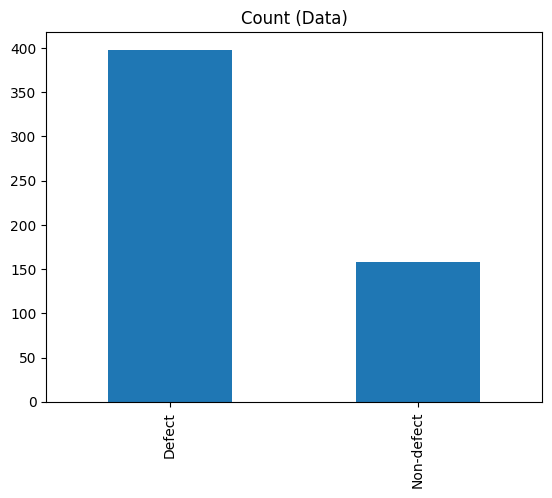

In [ ]:
target_count = df['category'].value_counts()
print('Category "Non-defect":', target_count[1])
print('Category "Defect":', target_count[0])
print('Proportion:', round(target_count[1] / target_count[0], 2), ': 1')

target_count.plot(kind='bar', title='Count (Data)')

In [ ]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

In [ ]:
image_paths = [os.path.join(imag_path, filename) for filename in os.listdir(imag_path ) if filename.endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
            transforms.RandomRotation(degrees=30),  # Random rotation up to 30 degrees
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Random affine transformation
            #transforms.RandomVerticalFlip(),  # Randomly flip vertically
            transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values
        ])

In [ ]:
# تبدیل تصاویر به تنسورها
images = [transform(Image.open(path)) for path in image_paths]

In [ ]:
# تبدیل به تنسور دسته‌های داده‌های ورودی
inputs = torch.stack(images)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(filepath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
df_dir = df['filepath'].values.tolist()
df_labels = df['category'].values
dataset = CustomImageDataset(df_dir, df_labels, transform=transform)

In [ ]:
pip install -U imbalanced-learn


In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE
import cv2  # OpenCV library for image processing

# Load and preprocess images
image_data = []
for file_path in df_dir:
    # Load the image and preprocess it
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = cv2.resize(image, (224, 224))  # Resize the image
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image_data.append(image)

# Convert image data to a NumPy array
X = np.array(image_data)

# Apply SMOTE to oversample the minority classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(-1, 224 * 224 * 3), df_labels)

# Create a new DataFrame with the resampled data
# Ensure that df_dir and y_resampled have the same length
resampled_file_paths = []

for i in range(len(X_resampled)):
    resampled_file_paths.append(df_dir[i % len(df_dir)])

df_resampled = pd.DataFrame({'filepath': resampled_file_paths, 'category': y_resampled})

# After applying SMOTE, check the class distribution again
target_count_resampled = df_resampled['category'].value_counts()
print('Class distribution after SMOTE:')
print(target_count_resampled)


Class distribution after SMOTE:
0    398
1    398
Name: category, dtype: int64


In [ ]:
# Calculate the number of augmentations per image
augmentation_factor = 1  # Start with the original image
augmentation_factor += 1  # Horizontal Flip
augmentation_factor += 1  # Rotation
augmentation_factor += 1  # Color Jitter

# Calculate the total number of images in the augmented dataset
original_dataset_size = len(df)
total_augmented_images = original_dataset_size * augmentation_factor

# Calculate the number of images added after data augmentation
images_added = total_augmented_images - original_dataset_size

print(f"Total images in the augmented dataset: {total_augmented_images}")
print(f"Number of images added after data augmentation: {images_added}")

Total images in the augmented dataset: 2224
Number of images added after data augmentation: 1668


In [ ]:
augmented_data = df_resampled.copy()
augmented_data['Augmented'] = True  # Add a column to mark augmented data
augmented_data = augmented_data.append([augmented_data] * (augmentation_factor - 1), ignore_index=True)

<ipython-input-47-97d6c007899b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append([augmented_data] * (augmentation_factor - 1), ignore_index=True)


In [ ]:
df_dir = augmented_data['filepath'].values.tolist()
df_labels = augmented_data['category'].values
dataset = CustomImageDataset(df_dir, df_labels, transform=transform)

In [ ]:
len(dataset)

3184

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()
        # لایه کانولوشنی اول
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه کانولوشنی دوم
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه کانولوشنی سوم
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه کانولوشنی چهارم
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه کانولوشنی پنجم
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(0.2)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه تمام متصل
        self.fc = nn.Linear(256 * 7 * 7, num_classes)  # در اینجا 7x7 اندازه خروجی می‌شود

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.maxpool5(x)

        x = x.view(x.size(0), -1)  # تغییر اندازه به یک بردار تمام متصل
        x = self.fc(x)
        return x

In [ ]:
model = CNNModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(

In [ ]:
batch_size = 32
num_classes = 2

num_folds = 5
num_epochs = 5


In [ ]:
df_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
len(df_loader)

100

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# تعریف یک KFold splitter
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
fold_accuracies = []
fold_losses = []
fold_train_losses = []
fold_test_losses = []
fold_conf_matrices = []
all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import time

start_total_time = time.time()

for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    print(f"Fold: {fold + 1}")

    # Create subsets of data for training and evaluation for this fold
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    # Create DataLoaders for training and evaluation
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

    # Initialize your model, optimizer, and loss function here

    train_accuracies = []  # List to store training accuracies for each epoch
    test_accuracies = []   # List to store test accuracies for each epoch

    train_losses = []  # List to store training losses for each epoch
    test_losses = []   # List to store test losses for each epoch

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        epoch_loss = 0.0  # Initialize the epoch loss to zero

        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate the loss for this batch

        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the epoch execution time
        # Append the average training loss for this epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate the model on the training set
        model.eval()
        with torch.no_grad():
            total_train = 0
            correct_train = 0

            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()

            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)

            # Evaluate the model on the test set
            total_test = 0
            correct_test = 0
            all_targets = []
            all_predictions = []

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            test_accuracy = 100 * correct_test / total_test
            test_accuracies.append(test_accuracy)

            # Calculate and store the test loss
            test_loss = criterion(outputs, targets).item()
            test_losses.append(test_loss)

            # Calculate and store the confusion matrix
            conf_matrix = confusion_matrix(all_targets, all_predictions, labels=list(range(num_classes)))
            fold_conf_matrices.append(conf_matrix)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_losses[-1]:.4f}, Epoch Time: {epoch_time:.2f} seconds')

    # Store training and test losses for this fold
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)
    # Store accuracies for this fold
    fold_accuracies.append((train_accuracies, test_accuracies))

    # Append accuracy and loss values across all epochs for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)

    # Print confusion matrix for this fold
    print(f'Confusion Matrix - Fold {fold + 1}:')
    print(conf_matrix)

# محاسبه میانگین دقت و هزینه برای تمام fold ها
average_accuracy_train = sum(train_accuracies) / len(train_accuracies)
average_loss_train = sum(train_losses) / len(train_losses)
average_accuracy_test = sum(test_accuracies) / len(test_accuracies)
average_loss_test = sum(test_losses) / len(test_losses)
# Record the end time after all folds and epochs are completed
end_total_time = time.time()

# Calculate the total execution time
total_execution_time = end_total_time - start_total_time



print(f'Average Accuracy_train: {average_accuracy_train:.4f}, Average Loss_train: {average_loss_train:.4f}, , Average Accuracy_test: {average_accuracy_test:.4f}, Average Loss_test: {average_loss_test:.4f}, Total Execution Time: {total_execution_time:.2f} seconds')


Fold: 1
Epoch [1/5], Train Accuracy: 57.0475, Train Loss: 1.9593, Test Accuracy: 57.1429, Test Loss: 1.0829, Epoch Time: 43.89 seconds
Epoch [2/5], Train Accuracy: 48.9203, Train Loss: 1.3602, Test Accuracy: 48.6656, Test Loss: 1.8117, Epoch Time: 41.30 seconds
Epoch [3/5], Train Accuracy: 51.4723, Train Loss: 1.0815, Test Accuracy: 53.5322, Test Loss: 1.7711, Epoch Time: 41.00 seconds
Epoch [4/5], Train Accuracy: 49.7055, Train Loss: 1.2070, Test Accuracy: 51.1774, Test Loss: 21.7502, Epoch Time: 40.99 seconds
Epoch [5/5], Train Accuracy: 50.7263, Train Loss: 1.1621, Test Accuracy: 53.6892, Test Loss: 4.3038, Epoch Time: 41.47 seconds
Confusion Matrix - Fold 1:
[[ 40 271]
 [ 24 302]]
Fold: 2
Epoch [1/5], Train Accuracy: 52.6109, Train Loss: 1.0065, Test Accuracy: 53.2182, Test Loss: 1.0996, Epoch Time: 41.27 seconds
Epoch [2/5], Train Accuracy: 57.3616, Train Loss: 0.9671, Test Accuracy: 56.2009, Test Loss: 1.1205, Epoch Time: 41.36 seconds
Epoch [3/5], Train Accuracy: 55.6341, Train 

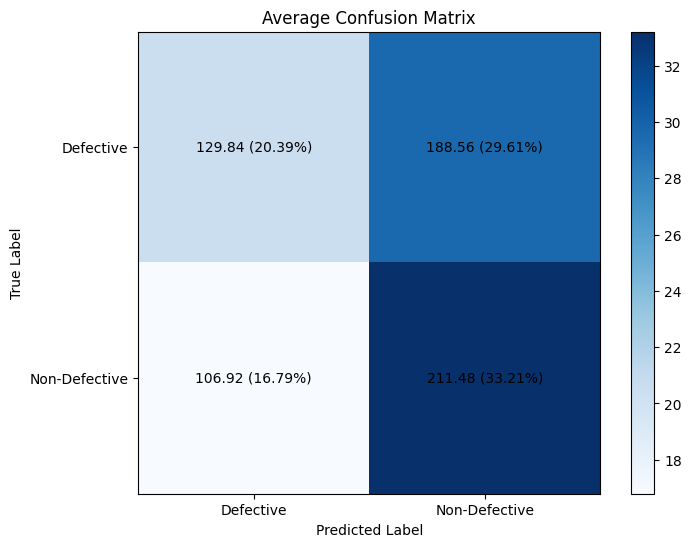

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the confusion matrices from all folds to calculate the average
average_conf_matrix = np.mean(fold_conf_matrices, axis=0)

# Define class labels
class_labels = ['Defective', 'Non-Defective']

# Calculate percentages for each quadrant
total_samples = np.sum(average_conf_matrix)
percentage_conf_matrix = (average_conf_matrix / total_samples) * 100

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(percentage_conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add labels to the axes
plt.title('Average Confusion Matrix')
plt.colorbar()

# Add class labels and percentages to the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = f'{average_conf_matrix[i, j]} ({percentage_conf_matrix[i, j]:.2f}%)'
        plt.text(j, i, text, horizontalalignment='center', verticalalignment='center', color='black')

# Set axis labels
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


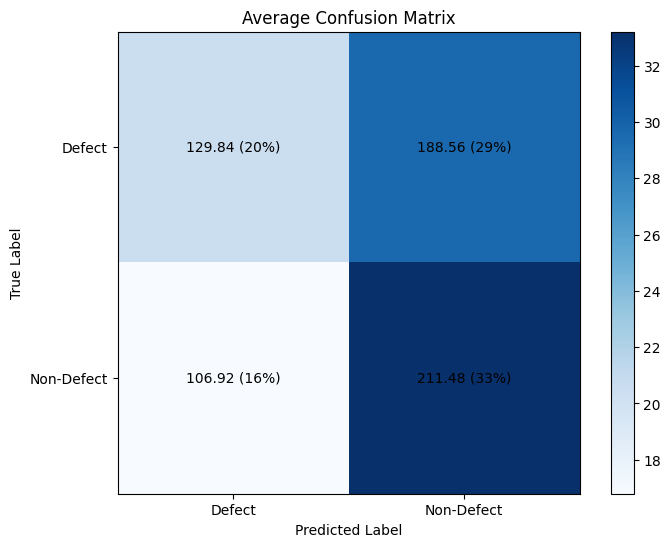

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the confusion matrices from all folds to calculate the average
average_conf_matrix = np.mean(fold_conf_matrices, axis=0)

# Define class labels
class_labels = ['Defect', 'Non-Defect']

# Calculate percentages for each quadrant using positive and negative ones
total_samples = np.sum(average_conf_matrix)
percentage_conf_matrix = (average_conf_matrix / total_samples) * 100

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(percentage_conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add labels to the axes
plt.title('Average Confusion Matrix')
plt.colorbar()

# Add class labels and percentages (with positive and negative ones) to the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = f'{average_conf_matrix[i, j]} ({int(percentage_conf_matrix[i, j])}%)'  # Use int() to remove decimals
        plt.text(j, i, text, horizontalalignment='center', verticalalignment='center', color='black')

# Set axis labels
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


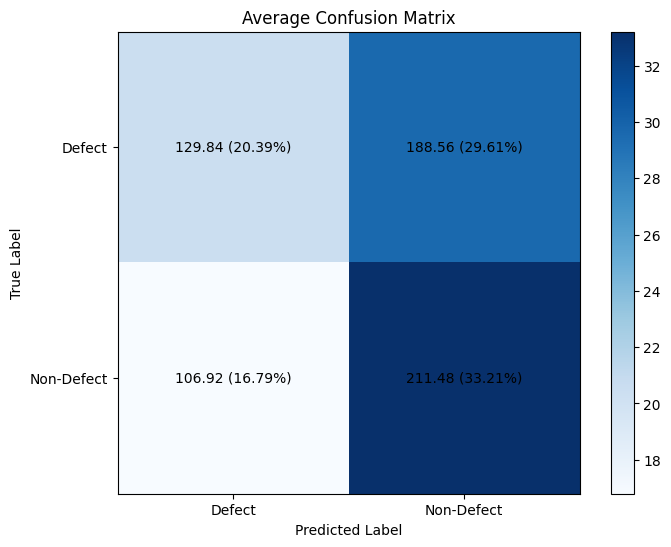

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the confusion matrices from all folds to calculate the average
average_conf_matrix = np.mean(fold_conf_matrices, axis=0)

# Define class labels
class_labels = ['Defect', 'Non-Defect']

# Calculate percentages for each quadrant using positive and negative ones
total_samples = np.sum(average_conf_matrix)
percentage_conf_matrix = (average_conf_matrix / total_samples) * 100

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(percentage_conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add labels to the axes
plt.title('Average Confusion Matrix')
plt.colorbar()

# Add class labels and percentages (with positive and negative ones) to the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        rounded_percentage = round(percentage_conf_matrix[i, j], 2)  # Round to 2 decimal places
        text = f'{average_conf_matrix[i, j]} ({rounded_percentage}%)'
        plt.text(j, i, text, horizontalalignment='center', verticalalignment='center', color='black')



# Set axis labels
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


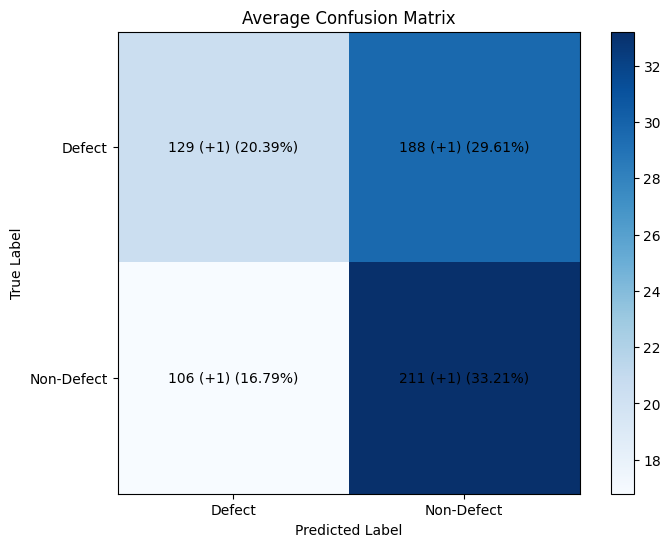

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the confusion matrices from all folds to calculate the average
average_conf_matrix = np.mean(fold_conf_matrices, axis=0)

# Define class labels
class_labels = ['Defect', 'Non-Defect']

# Calculate percentages for each quadrant using positive and negative ones
total_samples = np.sum(average_conf_matrix)
percentage_conf_matrix = (average_conf_matrix / total_samples) * 100

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(percentage_conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add labels to the axes
plt.title('Average Confusion Matrix')
plt.colorbar()

# Add class labels and modified format to the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        average_value = int(average_conf_matrix[i, j])  # Convert to integer
        percentage_value = round(percentage_conf_matrix[i, j], 2)  # Round to 2 decimal places
        if average_value >= 0:
            text = f'{average_value} (+1) ({percentage_value}%)'
            color = 'white' if percentage_value >= 50 else 'black'
        else:
            text = f'{average_value} (-1) ({percentage_value}%)'
            color = 'white' if percentage_value <= 50 else 'black'
        plt.text(j, i, text, horizontalalignment='center', verticalalignment='center', color=color)

# Set axis labels
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



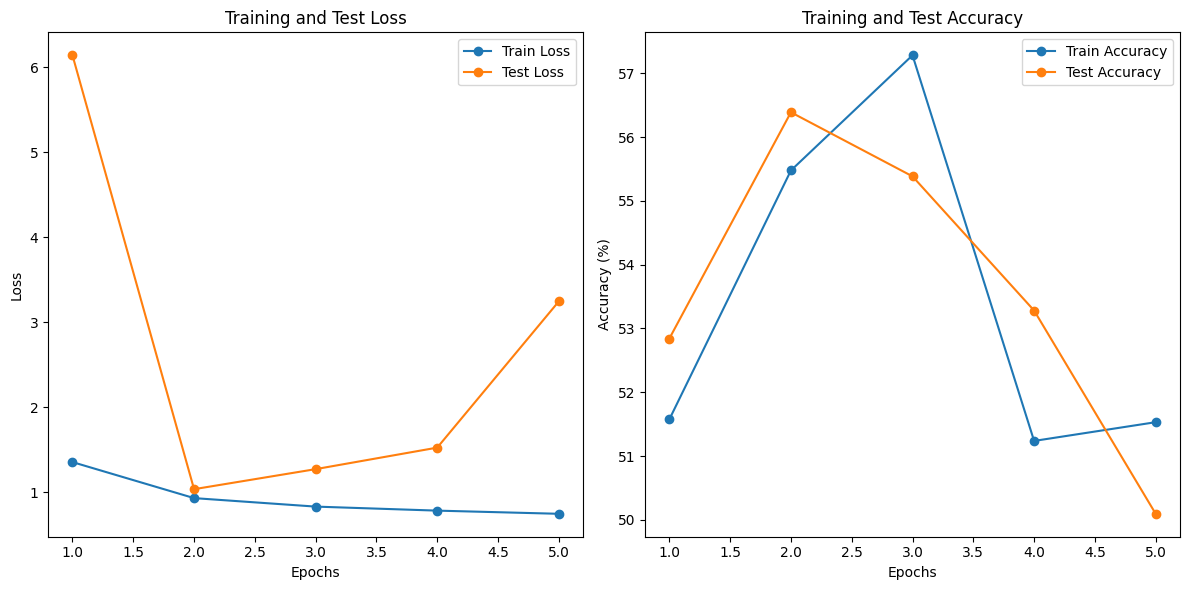

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average values for training and test metrics across all folds and epochs
average_train_losses = [np.mean(epoch_train_losses) for epoch_train_losses in all_train_losses]
average_test_losses = [np.mean(epoch_test_losses) for epoch_test_losses in all_test_losses]
average_train_accuracies = [np.mean(epoch_train_accuracies) for epoch_train_accuracies in all_train_accuracies]
average_test_accuracies = [np.mean(epoch_test_accuracies) for epoch_test_accuracies in all_test_accuracies]

# Create a list of epoch numbers for the x-axis
epochs = list(range(1, num_epochs + 1))

# Plot the training loss and test loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, average_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, average_test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot the training accuracy and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, average_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, average_test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class_names = ["Defect", "Non-Defect"]
class_labels = class_names

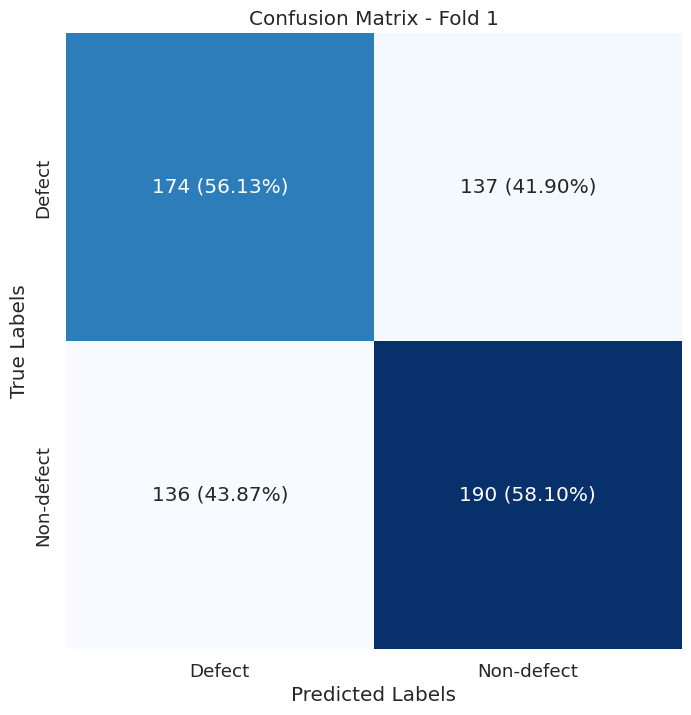

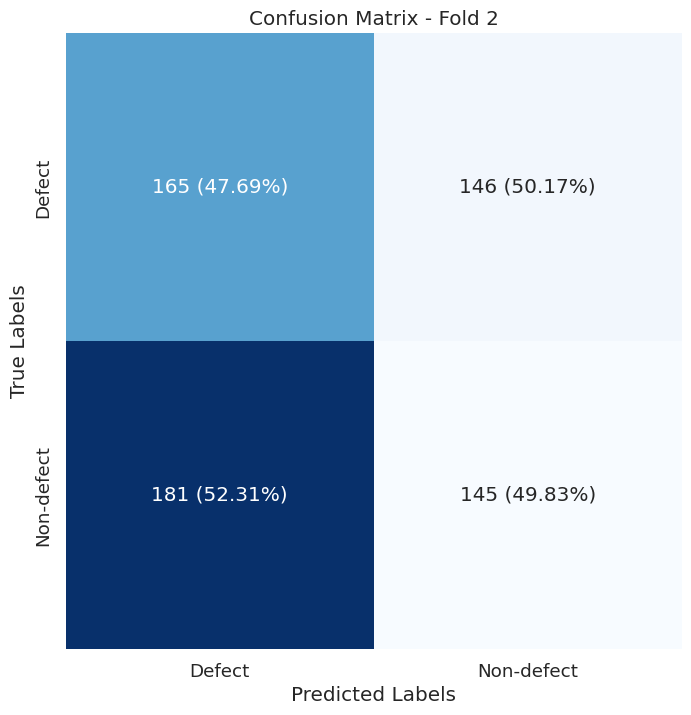

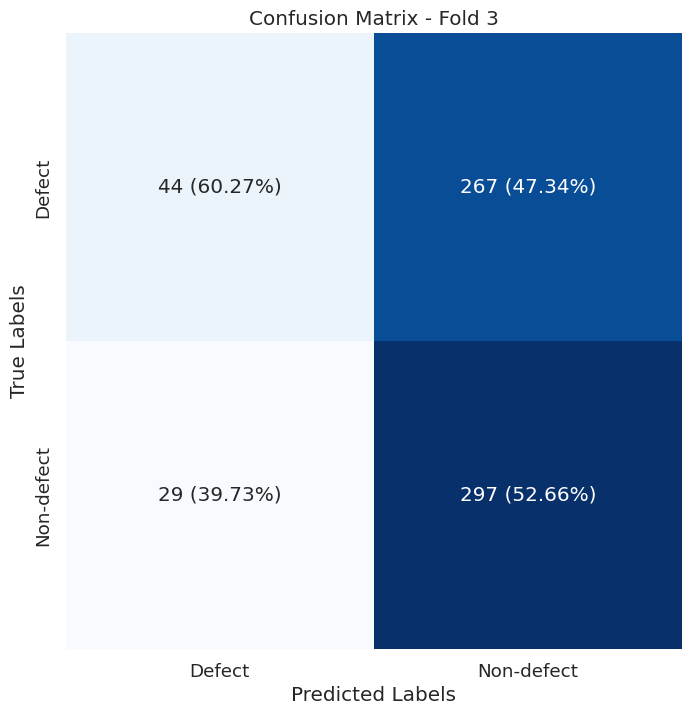

<ipython-input-66-99b986b50ece>:14: RuntimeWarning: invalid value encountered in divide
  percentages = (conf_matrix / total_samples) * 100


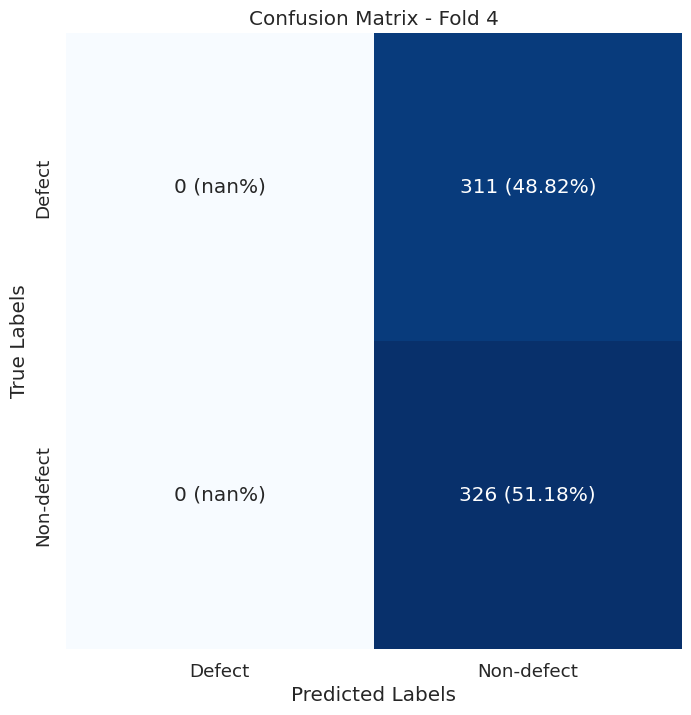

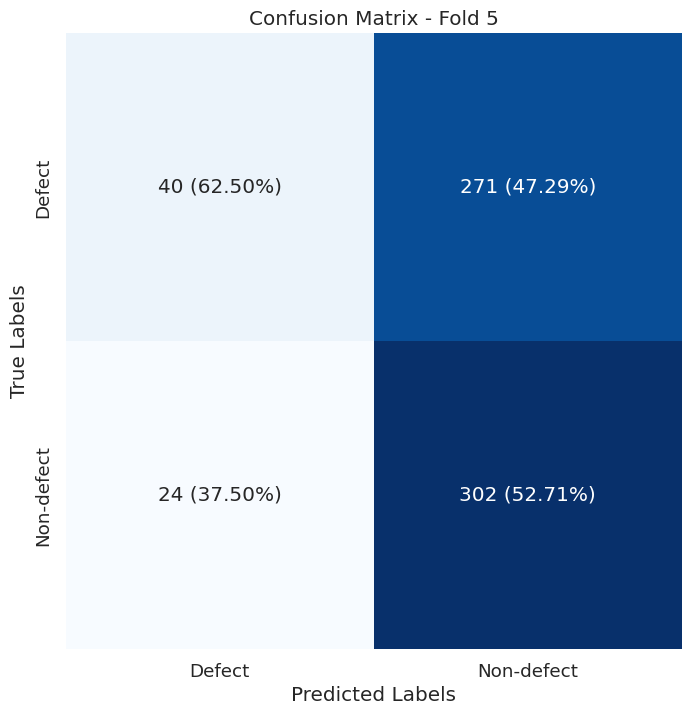

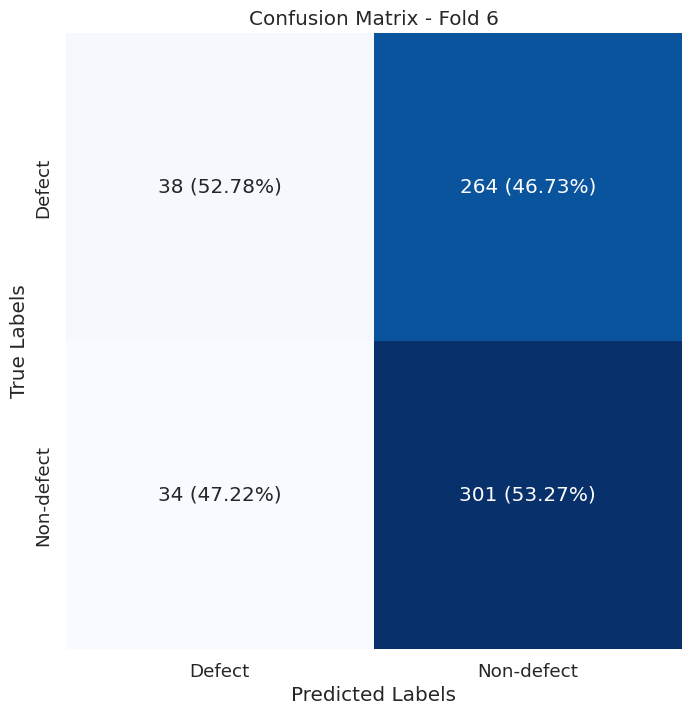

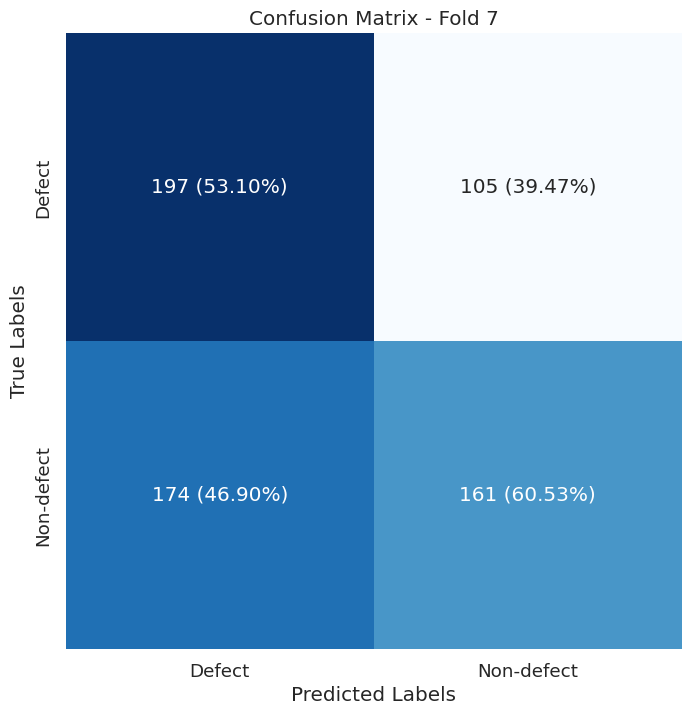

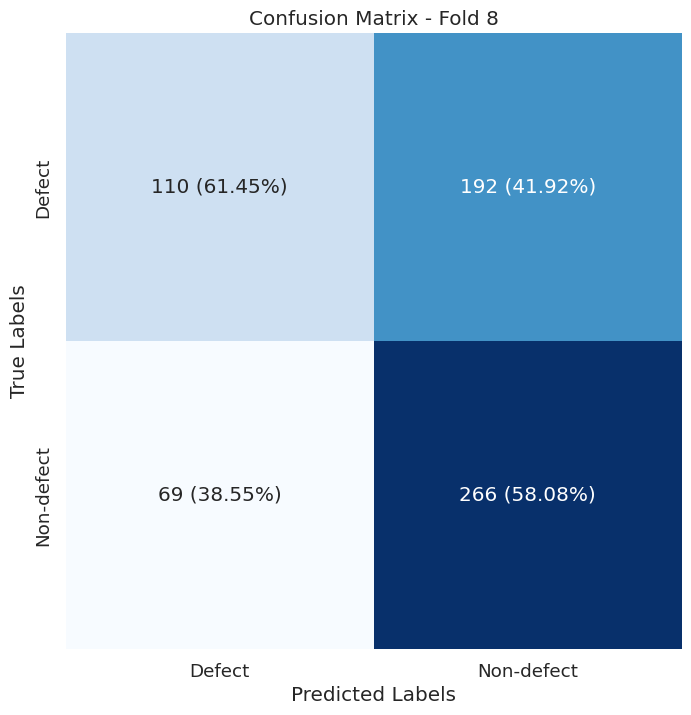

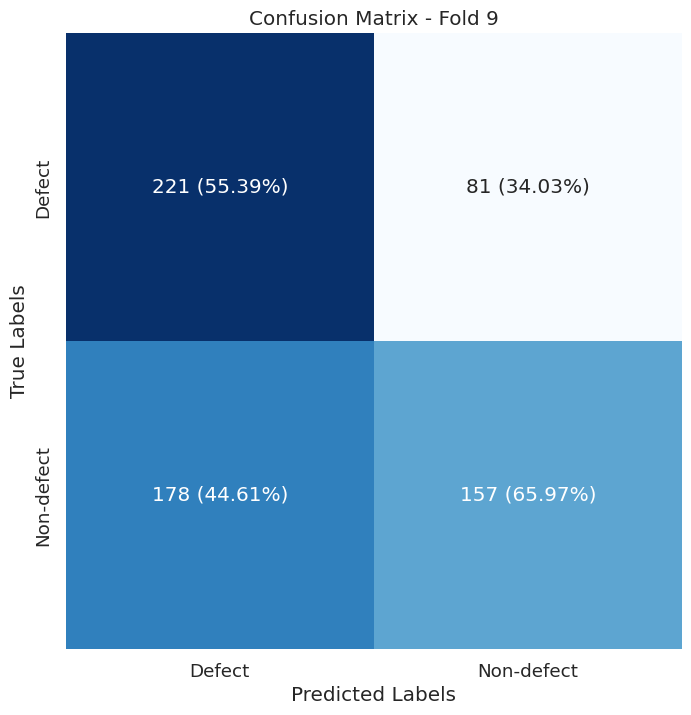

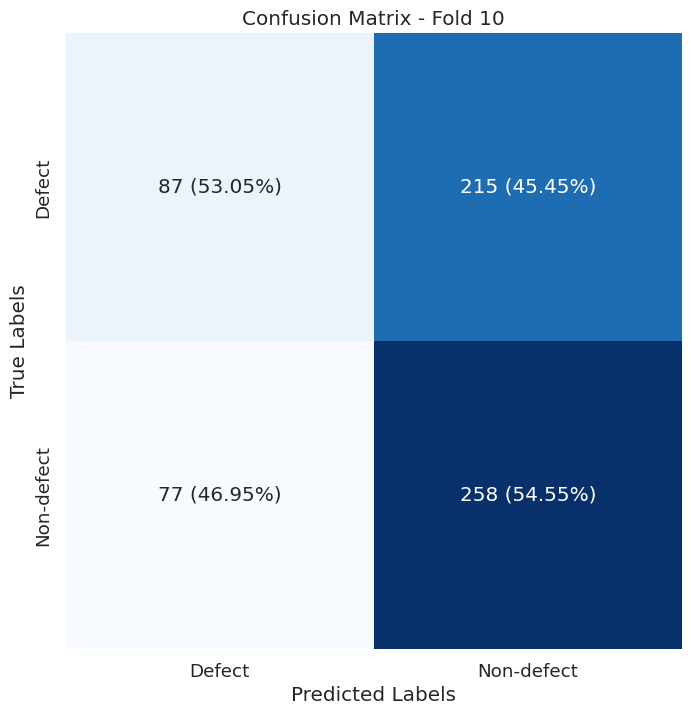

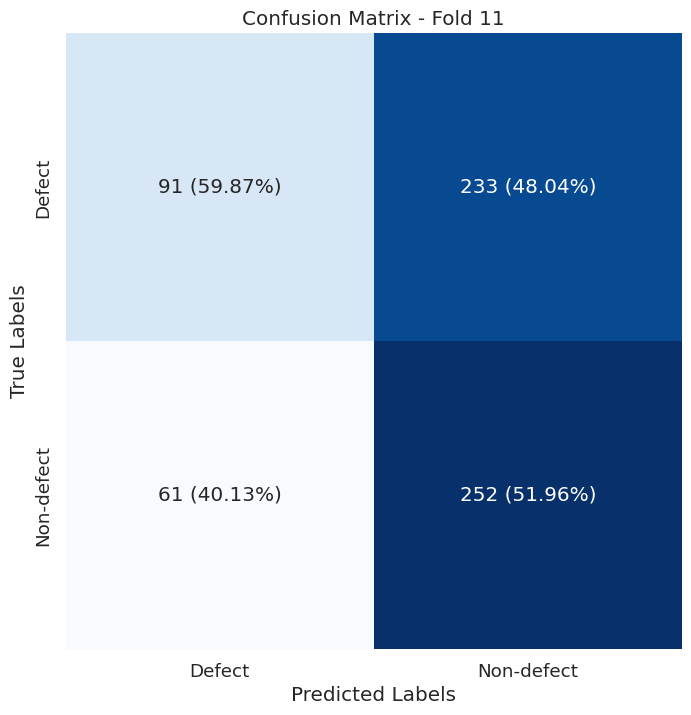

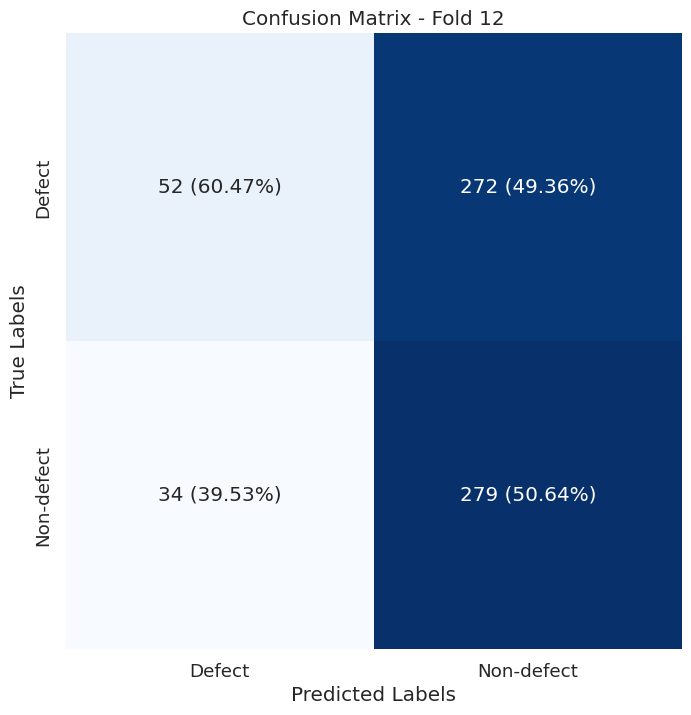

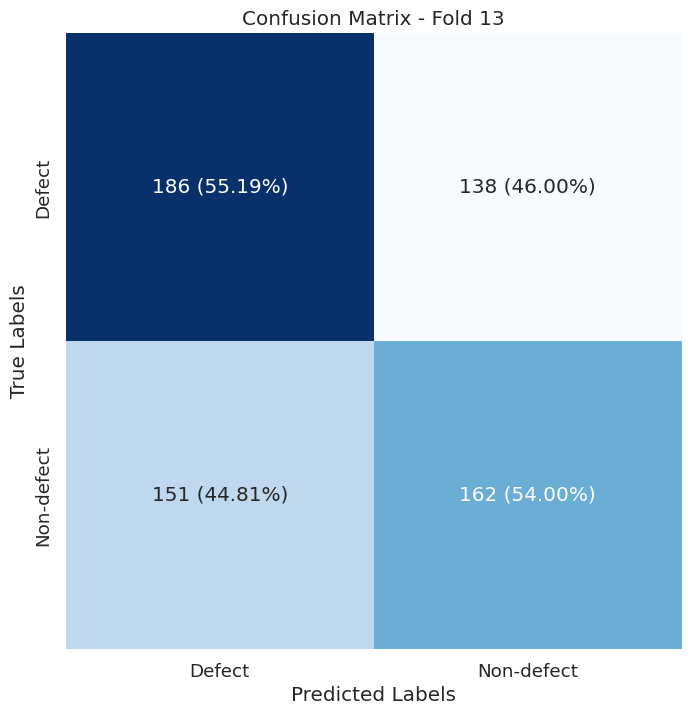

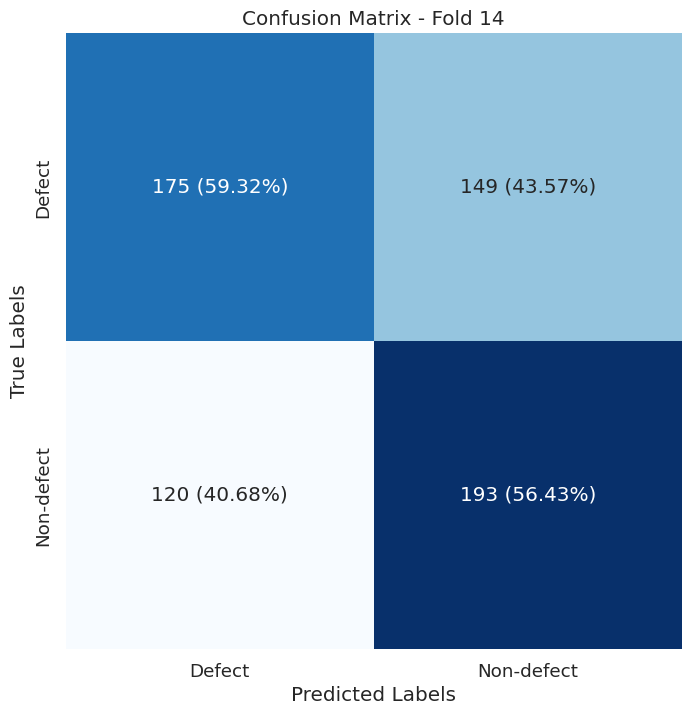

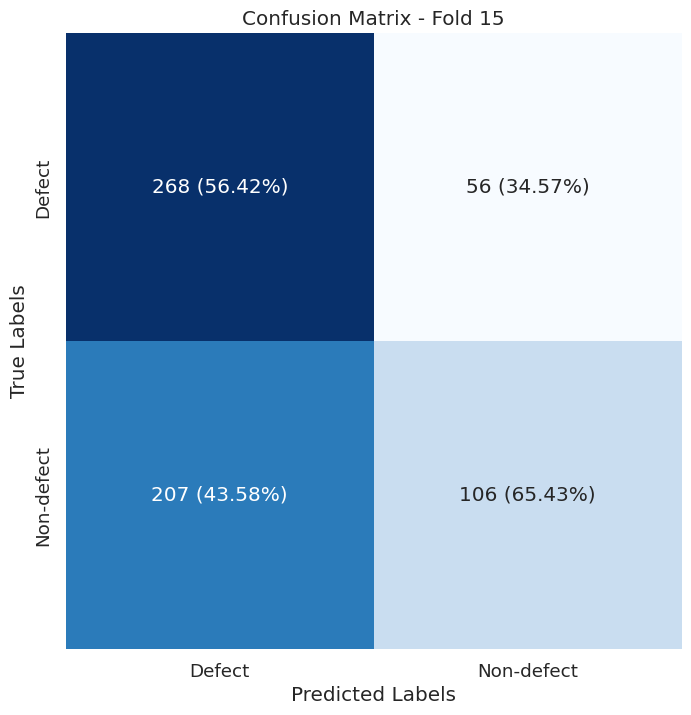

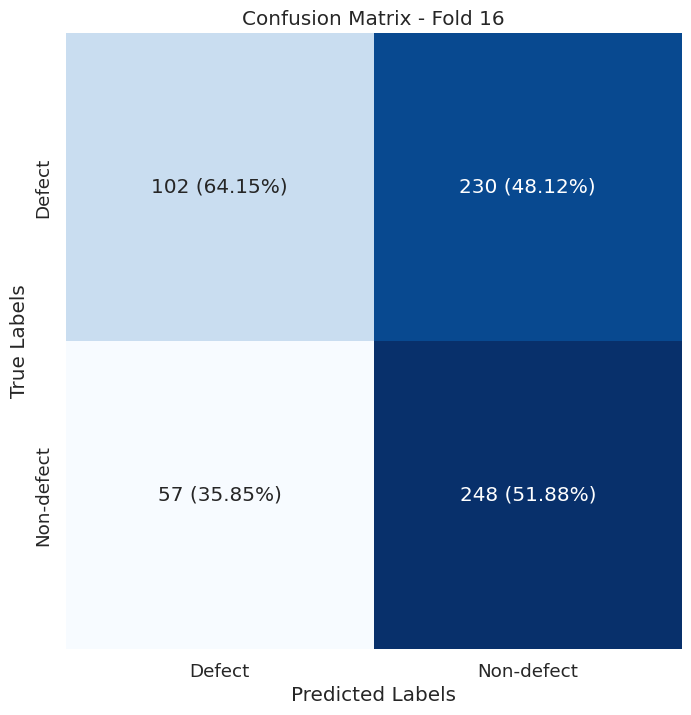

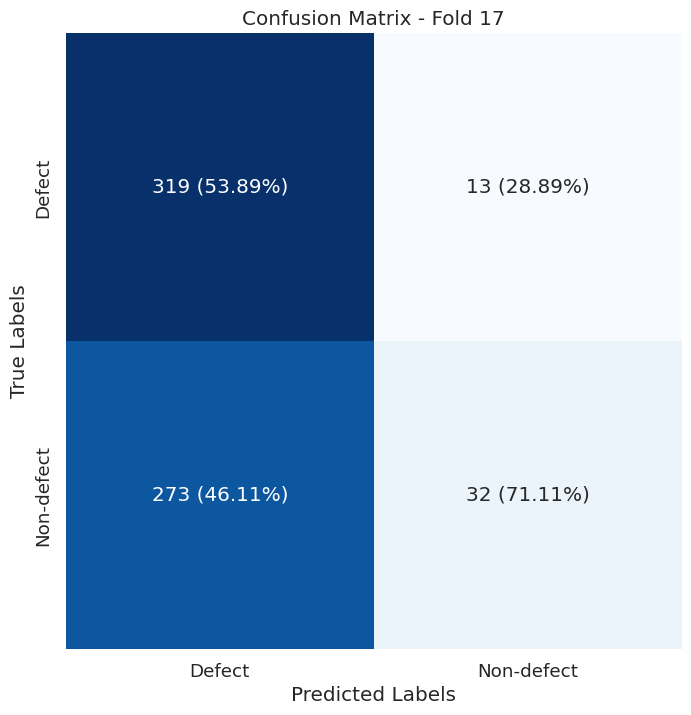

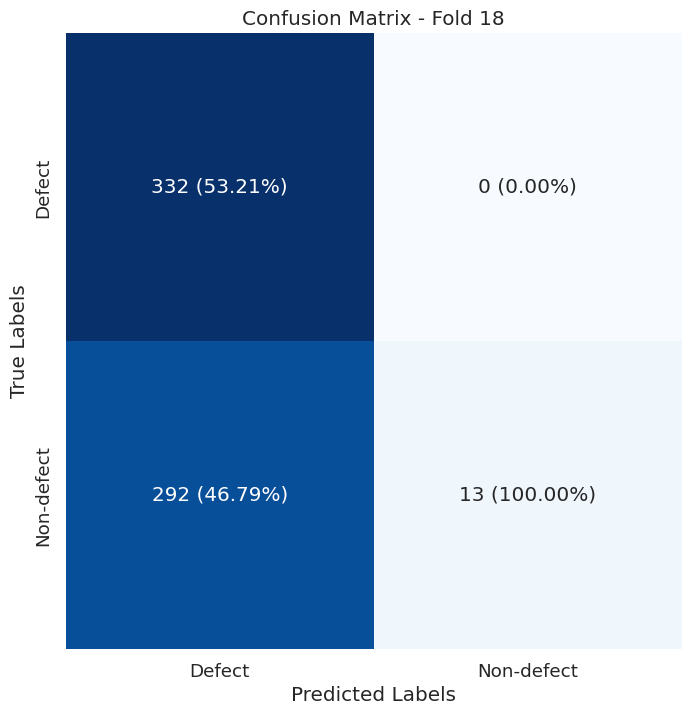

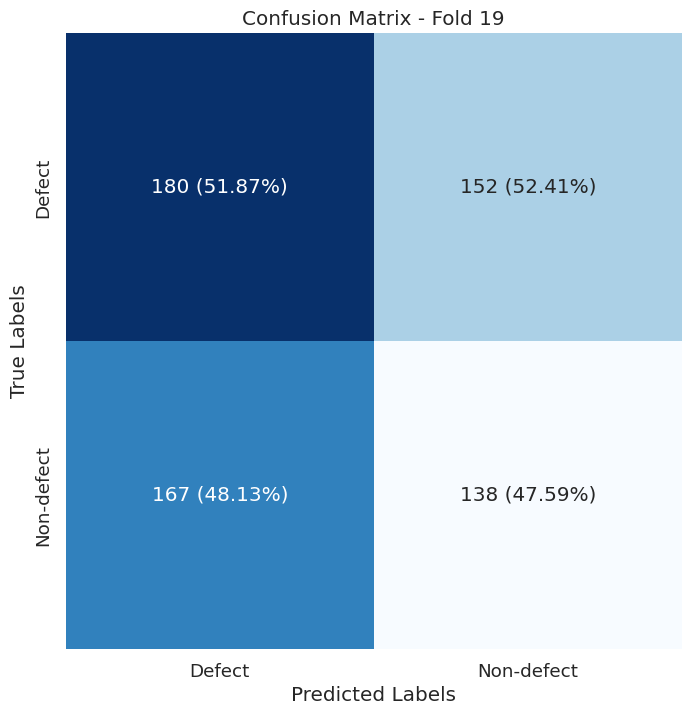

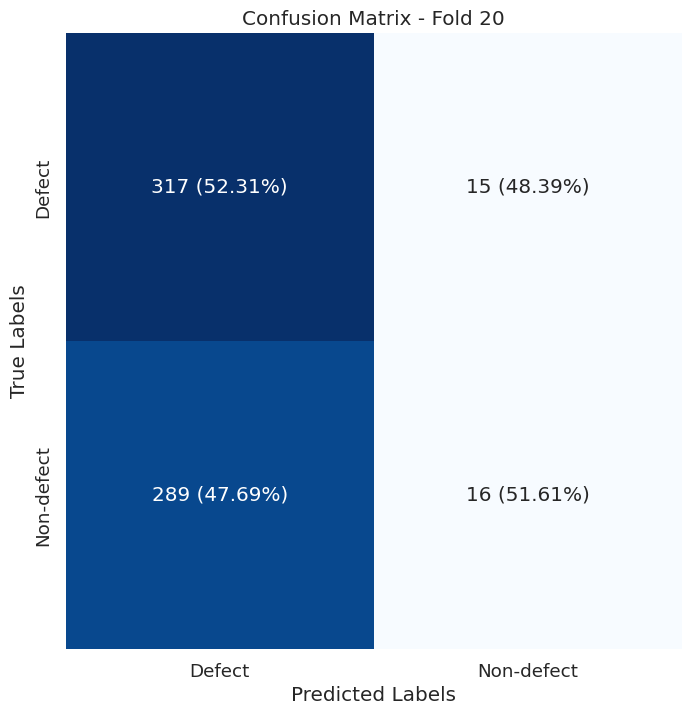

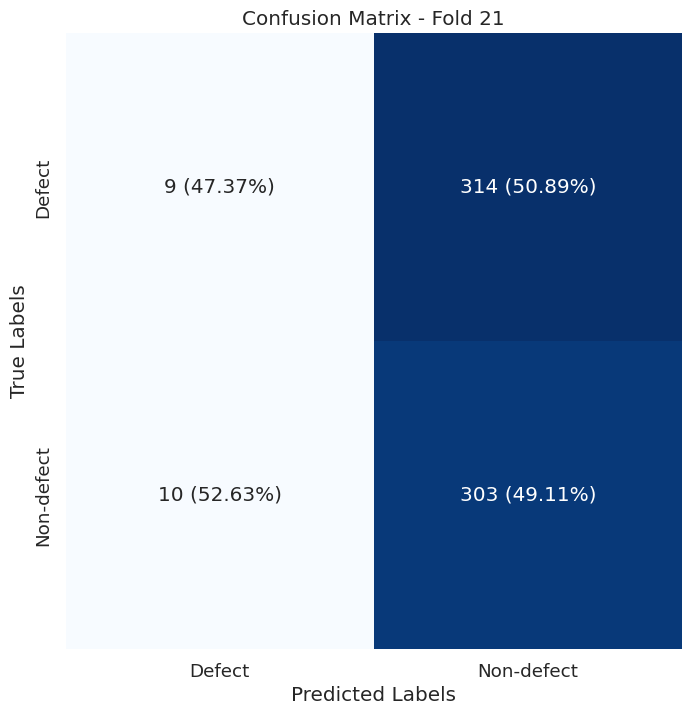

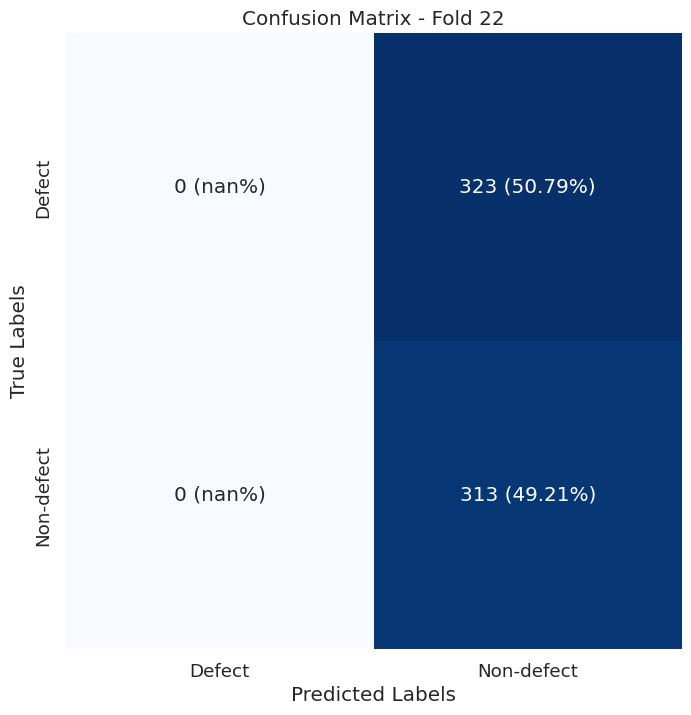

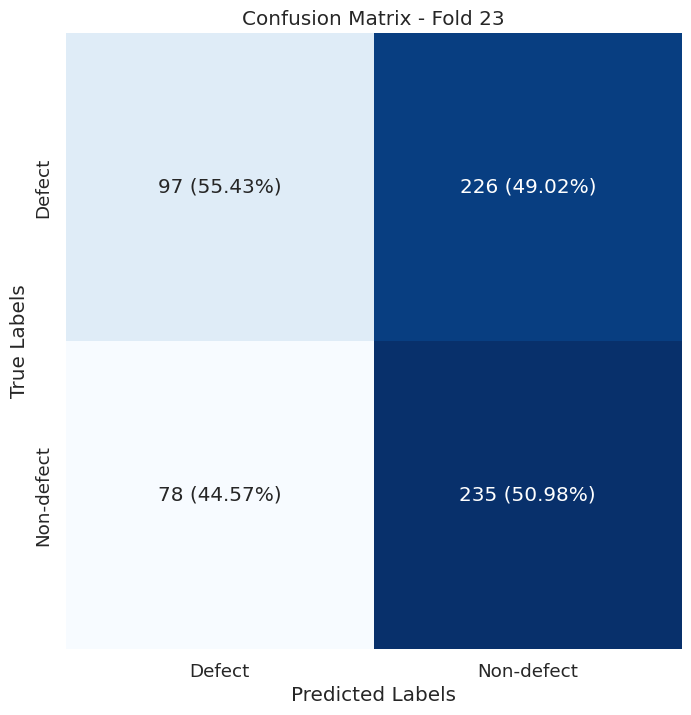

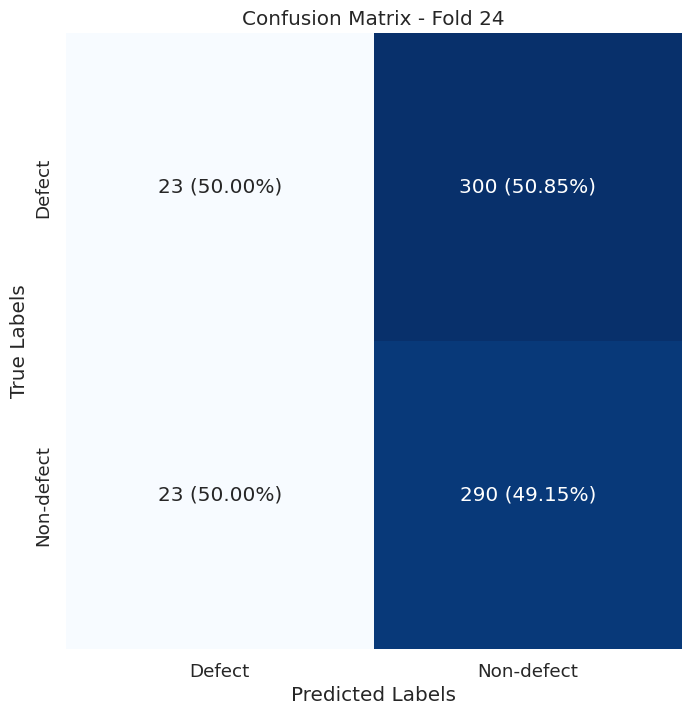

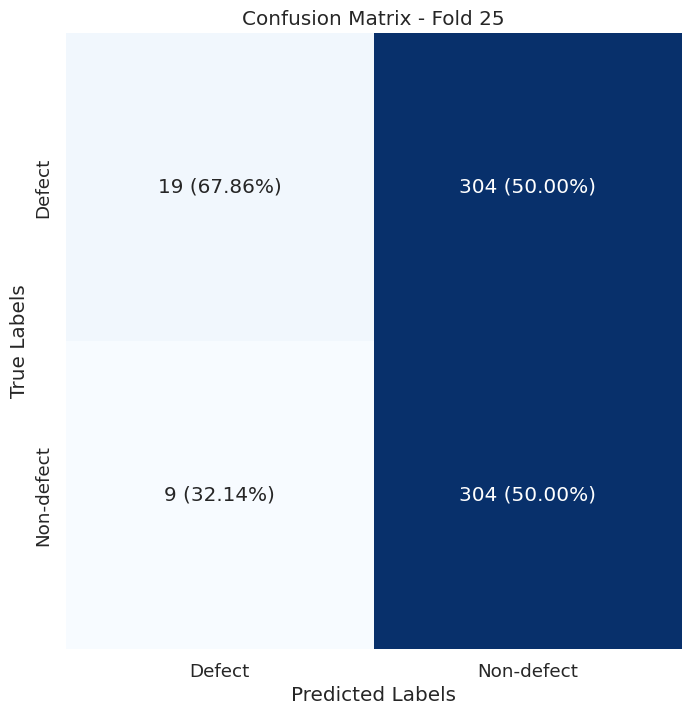

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot the confusion matrix as a table with percentages
def plot_confusion_matrix_with_percentages(conf_matrix, class_labels, fold):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)

    # Calculate the total number of samples (TP + TN + FP + FN)
    total_samples = sum(conf_matrix)

    # Calculate and add percentages to the confusion matrix
    percentages = (conf_matrix / total_samples) * 100
    percentages = percentages.round(2)  # Round percentages to two decimal places

    # Create a table with confusion matrix values and percentages
    table_data = []
    for i in range(len(class_labels)):
        row = []
        for j in range(len(class_labels)):
            value = f'{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)'
            row.append(value)
        table_data.append(row)

    ax = sns.heatmap(conf_matrix, annot=table_data, fmt="", cmap="Blues", cbar=False, square=True,
                     xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

# Plot confusion matrices with percentages for each fold
for fold, conf_matrix in enumerate(fold_conf_matrices):
    class_labels = ["Defect", "Non-defect"]  # Update class names
    plot_confusion_matrix_with_percentages(conf_matrix, class_labels, fold)


In [ ]:
# Calculate Prediction Accuracy
accuracy = (average_conf_matrix.diagonal().sum()) / (average_conf_matrix.sum())

# Calculate Sensitivity (True Positive Rate)
sensitivity = average_conf_matrix[1, 1] / (average_conf_matrix[1, 1] + average_conf_matrix[1, 0])

# Calculate Specificity (True Negative Rate)
specificity = average_conf_matrix[0, 0] / (average_conf_matrix[0, 0] + average_conf_matrix[0, 1])

# Calculate Precision (Positive Predictive Value)
precision = average_conf_matrix[1, 1] / (average_conf_matrix[1, 1] + average_conf_matrix[0, 1])

# Calculate F1 Score
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f'Prediction Accuracy: {accuracy:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1_score:.4f}')


Prediction Accuracy: 0.5360
Sensitivity: 0.6642
Specificity: 0.4078
Precision: 0.5286
F1 Score: 0.5887


In [ ]:
def calculate_metrics(conf_matrix):
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity)

    return accuracy, sensitivity, specificity, precision, f1_score

# Calculate metrics for each fold and print the results
for fold, conf_matrix in enumerate(fold_conf_matrices):
    accuracy, sensitivity, specificity, precision, f1_score = calculate_metrics(conf_matrix)
    print(f'Fold {fold + 1}:')
    print(f'Prediction Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1_score:.4f}')
    print()


Fold 1:
Prediction Accuracy: 0.5714
Sensitivity: 0.5828
Specificity: 0.5595
Precision: 0.5810
F1 Score: 0.5819

Fold 2:
Prediction Accuracy: 0.4867
Sensitivity: 0.4448
Specificity: 0.5305
Precision: 0.4983
F1 Score: 0.4700

Fold 3:
Prediction Accuracy: 0.5353
Sensitivity: 0.9110
Specificity: 0.1415
Precision: 0.5266
F1 Score: 0.6674

Fold 4:
Prediction Accuracy: 0.5118
Sensitivity: 1.0000
Specificity: 0.0000
Precision: 0.5118
F1 Score: 0.6771

Fold 5:
Prediction Accuracy: 0.5369
Sensitivity: 0.9264
Specificity: 0.1286
Precision: 0.5271
F1 Score: 0.6719

Fold 6:
Prediction Accuracy: 0.5322
Sensitivity: 0.8985
Specificity: 0.1258
Precision: 0.5327
F1 Score: 0.6689

Fold 7:
Prediction Accuracy: 0.5620
Sensitivity: 0.4806
Specificity: 0.6523
Precision: 0.6053
F1 Score: 0.5358

Fold 8:
Prediction Accuracy: 0.5903
Sensitivity: 0.7940
Specificity: 0.3642
Precision: 0.5808
F1 Score: 0.6709

Fold 9:
Prediction Accuracy: 0.5934
Sensitivity: 0.4687
Specificity: 0.7318
Precision: 0.6597
F1 Score: 

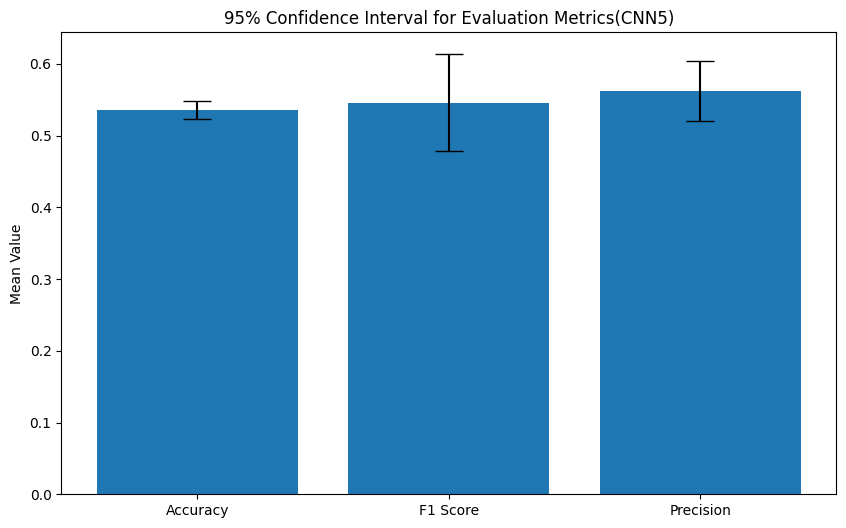

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have collected the evaluation metrics for each fold
# Replace these placeholders with your actual data
fold_accuracies = [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079]

fold_f1_scores = [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]

fold_precisions = [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]




# Remove None values from fold_f1_scores
fold_f1_scores_cleaned = [score for score in fold_f1_scores if score is not None]

fold_precisions_cleaned = [score for score in fold_precisions if score is not None]
# Calculate mean and standard deviation for each metric
mean_accuracies = np.mean(fold_accuracies)
std_accuracies = np.std(fold_accuracies)
mean_f1_scores = np.mean(fold_f1_scores_cleaned)
std_f1_scores = np.std(fold_f1_scores_cleaned)
mean_precisions = np.mean(fold_precisions_cleaned)
std_precisions = np.std(fold_precisions_cleaned)

# Define the confidence level (95% confidence interval)
confidence_level = 0.95

# Calculate the margin of error for each metric
margin_error_accuracy = 1.96 * (std_accuracies / np.sqrt(len(fold_accuracies)))
margin_error_f1_score = 1.96 * (std_f1_scores / np.sqrt(len(fold_f1_scores)))
margin_error_precision = 1.96 * (std_precisions / np.sqrt(len(fold_precisions)))

# Calculate the lower and upper bounds of the confidence interval
lower_bound_accuracy = mean_accuracies - margin_error_accuracy
upper_bound_accuracy = mean_accuracies + margin_error_accuracy
lower_bound_f1_score = mean_f1_scores - margin_error_f1_score
upper_bound_f1_score = mean_f1_scores + margin_error_f1_score
lower_bound_precision = mean_precisions - margin_error_precision
upper_bound_precision = mean_precisions + margin_error_precision

# Create a bar chart to visualize the confidence intervals
metrics = ['Accuracy', 'F1 Score', 'Precision']
mean_values = [mean_accuracies, mean_f1_scores, mean_precisions]
confidence_intervals = [
    (lower_bound_accuracy, upper_bound_accuracy),
    (lower_bound_f1_score, upper_bound_f1_score),
    (lower_bound_precision, upper_bound_precision)
]

plt.figure(figsize=(10, 6))
plt.bar(metrics, mean_values, yerr=[(upper - lower) / 2 for lower, upper in confidence_intervals], capsize=10)
plt.title('95% Confidence Interval for Evaluation Metrics(CNN5)')
plt.ylabel('Mean Value')
plt.show()


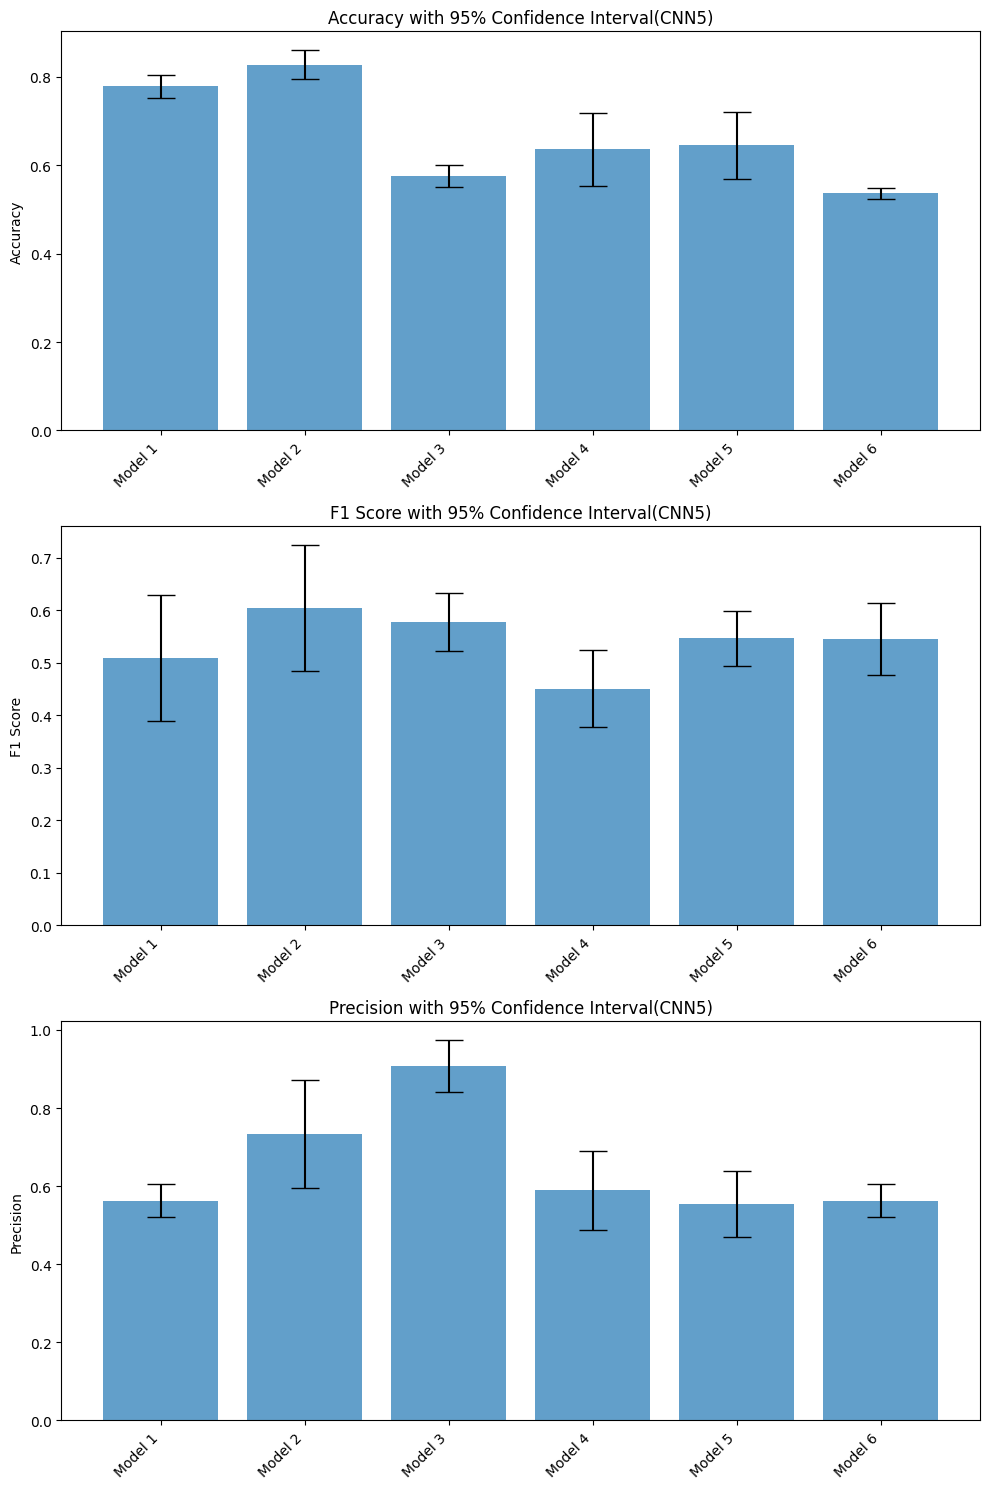

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for each model
models1 = ["CNN 5layer (without Augmentation and Balance)",
          "CNN 5layer (without Augmentation, with Weighting Balance)",
          "CNN 5layer (without Augmentation, with SMOTE Balance)",
          "CNN 5layer (with Augmentation, without Balance)",
          "CNN 5layer (with Augmentation, with Weighting Balance)",
          "CNN 5layer (with Augmentation, with SMOTE Balance)"]


models = ["Model 1",
          "Model 2",
          "Model 3",
          "Model 4",
          "Model 5",
          "Model 6"]
# Accuracy data for each model
accuracies = [[0.7500, 0.7679, 0.8839, 0.9018, 0.8304, 0.7207, 0.7748, 0.8018, 0.7477, 0.7748,
                            0.8108, 0.7477, 0.7207, 0.7387, 0.7297, 0.7387, 0.8108, 0.8378, 0.8288, 0.8919,
                            0.8649, 0.6937, 0.6937, 0.6937, 0.6937],
    [0.7500, 0.7500, 0.8929, 0.6875, 0.8304, 0.7207, 0.7207, 0.8559, 0.8649, 0.7207,
                            0.7387, 0.7838, 0.7748, 0.8018, 0.9550, 0.8378, 0.7658, 0.9099, 0.9459, 0.8739,
                            0.9009, 0.8378, 0.9099, 0.9279, 0.9279],
    [0.5312, 0.5312, 0.5938, 0.5062, 0.5563, 0.4717, 0.6855, 0.5283, 0.4969, 0.5975,
                            0.5031, 0.6478, 0.6415, 0.5409, 0.6792, 0.6289, 0.5975, 0.6352, 0.5597, 0.6289,
                            0.5786, 0.6730, 0.5283, 0.5283, 0.5094],
    [0.7528, 0.7865, 0.7169, 0.7146, 0.8404, 0.4607, 0.7888, 0.2787, 0.7685, 0.7236,
                            0.7596, 0.7303, 0.8382, 0.8000, 0.2809, 0.3191, 0.3213, 0.7236, 0.7978, 0.8449,
                            0.2950, 0.7072, 0.4234, 0.8604, 0.3536],
    [0.7618, 0.7483, 0.7146, 0.8292, 0.6966, 0.3169, 0.3573, 0.7865, 0.5483, 0.8045,
                            0.6247, 0.8292, 0.5708, 0.4067, 0.8360, 0.8629, 0.6449, 0.5124, 0.8719, 0.4494,
                            0.7703, 0.3108, 0.3131, 0.8176, 0.7275],
    [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079],
]

# F1 scores data for each model
f1_scores = [
    [ 0.6389, 0.7347, 0.7660, 0.7164, 0.0606, 0.6032, 0.5600, 0.2222, 0.4681, 0.5116,
                  0.0667,  0.2927, 0.5714, 0.6538, 0.6545, 0.8378, 0.7692,0.0556],
    [0.7500, 0.5977, 0.4865, 0.0606, 0.0606, 0.7949, 0.6939, 0.0606,
                  0.5000, 0.2424, 0.4211, 0.9123, 0.6538, 0.4091, 0.8333, 0.9118, 0.7500, 0.8070,
                  0.7805, 0.8438, 0.8667, 0.8667],
    [0.6939, 0.6939, 0.6632, 0.1319, 0.6502, 0.6283, 0.5000, 0.6479, 0.6296, 0.2195,
                  0.6030, 0.4286, 0.4865, 0.6178, 0.5920, 0.6289, 0.5077, 0.5972, 0.7131, 0.7489,
                  0.5988, 0.6119, 0.6231, 0.6114, 0.6355],
   [0.3678, 0.5887, 0.6500, 0.1806, 0.7078, 0.4937, 0.3974, 0.4278, 0.2993,
                  0.2302, 0.0625, 0.6364, 0.4258, 0.4203, 0.4656, 0.4664, 0.1633, 0.4944, 0.7294,
                  0.4538, 0.5039, 0.7304, 0.4753],
    [0.4536, 0.6543, 0.1361, 0.6885, 0.5545, 0.4391, 0.4500, 0.6122, 0.5336, 0.5672,
                  0.5751, 0.6042, 0.5375, 0.4656, 0.6218, 0.7550, 0.6108, 0.5489, 0.8068, 0.5168,
                  0.3625, 0.4594, 0.4583, 0.5930, 0.6667],
     [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]
]

# Precision data for each model
precisions = [
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000],
    [0.5227, 0.8571, 0.9474, 0.6154, 1.0000, 0.6129, 0.7778, 1.0000, 0.7333, 0.7857,
                   1.0000, 0.0000,  0.0000,  1.0000, 1.0000, 1.0000, 0.7949, 0.8065,  0.5000],
    [0.9000, 0.4407, 1.0000, 1.0000, 1.0000, 0.6739, 1.0000, 1.0000,
                   0.6316, 1.0000, 0.8889, 0.9286, 1.0000, 1.0000, 1.0000, 0.9394, 1.0000,
                   1.0000, 0.6667, 0.9000, 1.0000, 1.0000],
    [0.8000, 0.7010, 0.5177, 0.6667, 0.7890, 0.3305, 0.8611, 0.2721, 0.8148,
                   0.6957, 0.3333, 0.7683, 0.8462, 0.2661, 0.3034, 0.3041, 0.8000, 0.9565, 0.7561,
                   0.2935, 0.3368, 0.8400, 0.3118],
    [0.7333, 0.5579, 0.7692, 0.7636, 0.4970, 0.2820, 0.2925, 0.6000, 0.3698, 0.7037,
                   0.4079, 0.7632, 0.3737, 0.3042, 0.7792, 0.8034, 0.4526, 0.3782, 0.7301, 0.3493,
                   0.9667, 0.2982, 0.2979, 0.8551, 0.5193],
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]
]

# Calculate the mean and standard error for each model
mean_accuracies = [np.mean(acc) for acc in accuracies]
std_err_accuracies = [1.96 * np.std(acc, ddof=1) / np.sqrt(len(acc)) for acc in accuracies]

mean_f1_scores = [np.mean(f1) for f1 in f1_scores]
std_err_f1_scores = [1.96 * np.std(f1, ddof=1) / np.sqrt(len(f1)) for f1 in f1_scores]

mean_precisions = [np.mean(precision) for precision in precisions]
std_err_precisions = [1.96 * np.std(precision, ddof=1) / np.sqrt(len(precision)) for precision in precisions]

# Create x-values for the models
x = np.arange(len(models))

# Create subplots for accuracy, F1 score, and precision
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot accuracy with confidence intervals
axs[0].bar(x, mean_accuracies, yerr=std_err_accuracies, align='center', alpha=0.7, capsize=10)
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45, ha='right')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy with 95% Confidence Interval(CNN5)')

# Plot F1 score with confidence intervals
axs[1].bar(x, mean_f1_scores, yerr=std_err_f1_scores, align='center', alpha=0.7, capsize=10)
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45, ha='right')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('F1 Score with 95% Confidence Interval(CNN5)')

# Plot precision with confidence intervals
axs[2].bar(x, mean_precisions, yerr=std_err_precisions, align='center', alpha=0.7, capsize=10)
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=45, ha='right')
axs[2].set_ylabel('Precision')
axs[2].set_title('Precision with 95% Confidence Interval(CNN5)')

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-3-6d817332fbab>:240: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


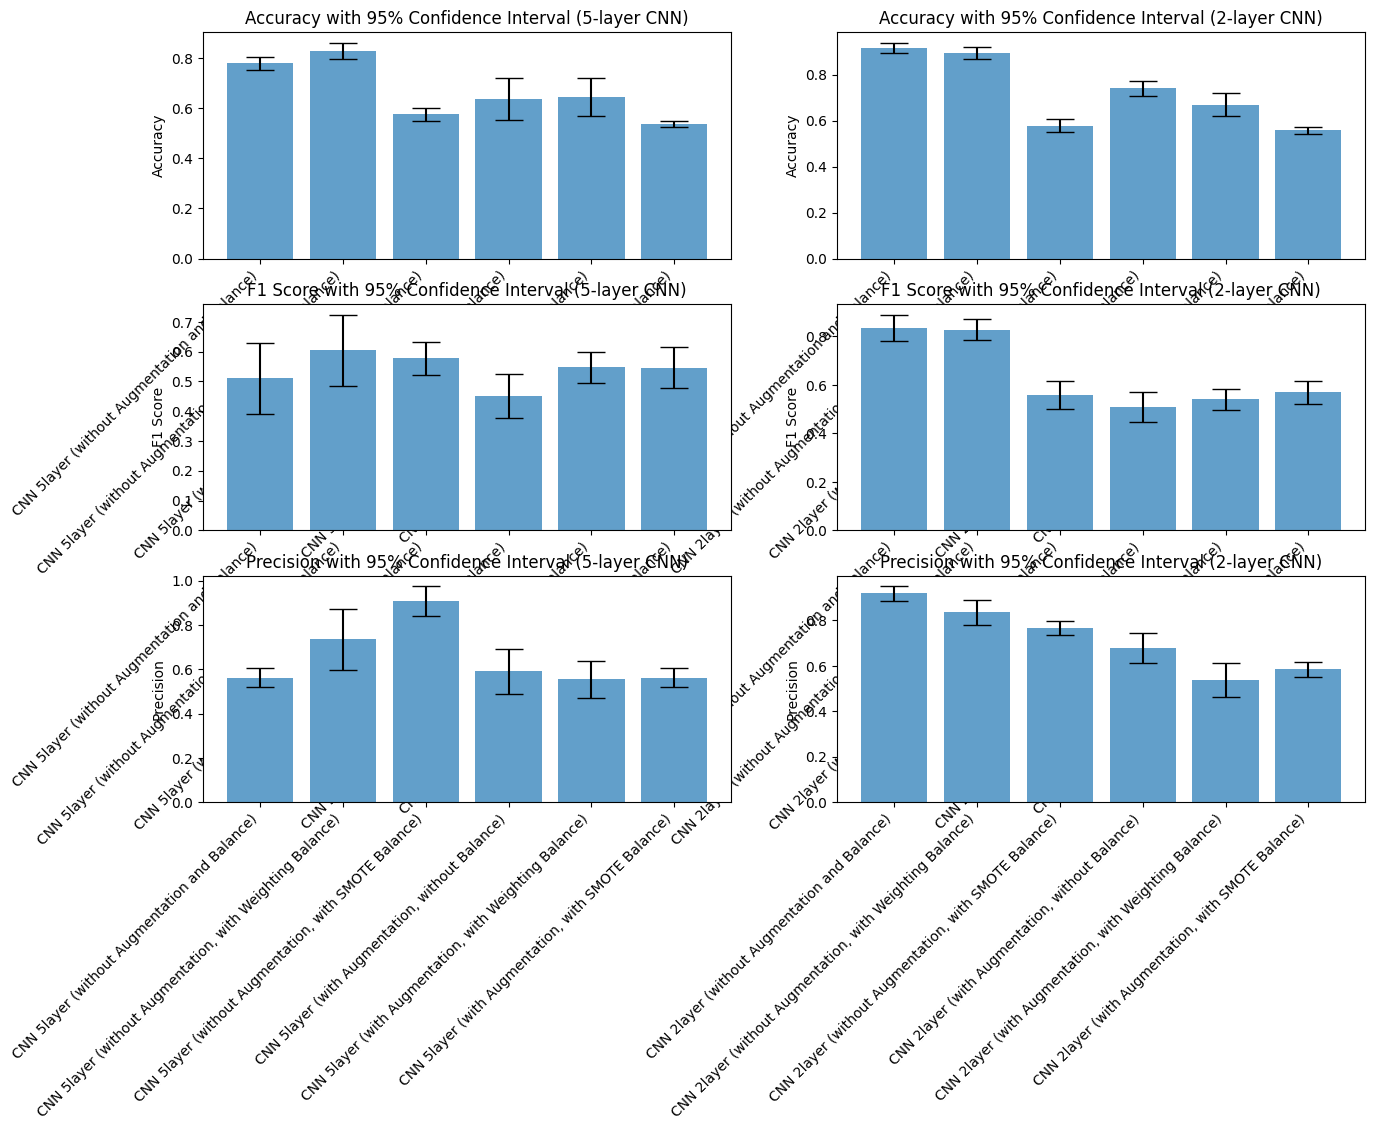

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for each model (5-layer CNN)
Strategy5 = ["CNN 5layer (without Augmentation and Balance)",
          "CNN 5layer (without Augmentation, with Weighting Balance)",
          "CNN 5layer (without Augmentation, with SMOTE Balance)",
          "CNN 5layer (with Augmentation, without Balance)",
          "CNN 5layer (with Augmentation, with Weighting Balance)",
          "CNN 5layer (with Augmentation, with SMOTE Balance)"]

strategy = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]

# Accuracy data for each model (5-layer CNN)
accuracies5 = [[0.7500, 0.7679, 0.8839, 0.9018, 0.8304, 0.7207, 0.7748, 0.8018, 0.7477, 0.7748,
                            0.8108, 0.7477, 0.7207, 0.7387, 0.7297, 0.7387, 0.8108, 0.8378, 0.8288, 0.8919,
                            0.8649, 0.6937, 0.6937, 0.6937, 0.6937],
    [0.7500, 0.7500, 0.8929, 0.6875, 0.8304, 0.7207, 0.7207, 0.8559, 0.8649, 0.7207,
                            0.7387, 0.7838, 0.7748, 0.8018, 0.9550, 0.8378, 0.7658, 0.9099, 0.9459, 0.8739,
                            0.9009, 0.8378, 0.9099, 0.9279, 0.9279],
    [0.5312, 0.5312, 0.5938, 0.5062, 0.5563, 0.4717, 0.6855, 0.5283, 0.4969, 0.5975,
                            0.5031, 0.6478, 0.6415, 0.5409, 0.6792, 0.6289, 0.5975, 0.6352, 0.5597, 0.6289,
                            0.5786, 0.6730, 0.5283, 0.5283, 0.5094],
    [0.7528, 0.7865, 0.7169, 0.7146, 0.8404, 0.4607, 0.7888, 0.2787, 0.7685, 0.7236,
                            0.7596, 0.7303, 0.8382, 0.8000, 0.2809, 0.3191, 0.3213, 0.7236, 0.7978, 0.8449,
                            0.2950, 0.7072, 0.4234, 0.8604, 0.3536],
    [0.7618, 0.7483, 0.7146, 0.8292, 0.6966, 0.3169, 0.3573, 0.7865, 0.5483, 0.8045,
                            0.6247, 0.8292, 0.5708, 0.4067, 0.8360, 0.8629, 0.6449, 0.5124, 0.8719, 0.4494,
                            0.7703, 0.3108, 0.3131, 0.8176, 0.7275],
    [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079],
]

# F1 scores data for each model (5-layer CNN)
f1_scores5 = [
    [ 0.6389, 0.7347, 0.7660, 0.7164, 0.0606, 0.6032, 0.5600, 0.2222, 0.4681, 0.5116,
                  0.0667,  0.2927, 0.5714, 0.6538, 0.6545, 0.8378, 0.7692,0.0556],
    [0.7500, 0.5977, 0.4865, 0.0606, 0.0606, 0.7949, 0.6939, 0.0606,
                  0.5000, 0.2424, 0.4211, 0.9123, 0.6538, 0.4091, 0.8333, 0.9118, 0.7500, 0.8070,
                  0.7805, 0.8438, 0.8667, 0.8667],
    [0.6939, 0.6939, 0.6632, 0.1319, 0.6502, 0.6283, 0.5000, 0.6479, 0.6296, 0.2195,
                  0.6030, 0.4286, 0.4865, 0.6178, 0.5920, 0.6289, 0.5077, 0.5972, 0.7131, 0.7489,
                  0.5988, 0.6119, 0.6231, 0.6114, 0.6355],
   [0.3678, 0.5887, 0.6500, 0.1806, 0.7078, 0.4937, 0.3974, 0.4278, 0.2993,
                  0.2302, 0.0625, 0.6364, 0.4258, 0.4203, 0.4656, 0.4664, 0.1633, 0.4944, 0.7294,
                  0.4538, 0.5039, 0.7304, 0.4753],
    [0.4536, 0.6543, 0.1361, 0.6885, 0.5545, 0.4391, 0.4500, 0.6122, 0.5336, 0.5672,
                  0.5751, 0.6042, 0.5375, 0.4656, 0.6218, 0.7550, 0.6108, 0.5489, 0.8068, 0.5168,
                  0.3625, 0.4594, 0.4583, 0.5930, 0.6667],
     [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]
]

# Precision data for each model (5-layer CNN)
precisions5 = [
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000],
    [0.5227, 0.8571, 0.9474, 0.6154, 1.0000, 0.6129, 0.7778, 1.0000, 0.7333, 0.7857,
                   1.0000, 0.0000,  0.0000,  1.0000, 1.0000, 1.0000, 0.7949, 0.8065,  0.5000],
    [0.9000, 0.4407, 1.0000, 1.0000, 1.0000, 0.6739, 1.0000, 1.0000,
                   0.6316, 1.0000, 0.8889, 0.9286, 1.0000, 1.0000, 1.0000, 0.9394, 1.0000,
                   1.0000, 0.6667, 0.9000, 1.0000, 1.0000],
    [0.8000, 0.7010, 0.5177, 0.6667, 0.7890, 0.3305, 0.8611, 0.2721, 0.8148,
                   0.6957, 0.3333, 0.7683, 0.8462, 0.2661, 0.3034, 0.3041, 0.8000, 0.9565, 0.7561,
                   0.2935, 0.3368, 0.8400, 0.3118],
    [0.7333, 0.5579, 0.7692, 0.7636, 0.4970, 0.2820, 0.2925, 0.6000, 0.3698, 0.7037,
                   0.4079, 0.7632, 0.3737, 0.3042, 0.7792, 0.8034, 0.4526, 0.3782, 0.7301, 0.3493,
                   0.9667, 0.2982, 0.2979, 0.8551, 0.5193],
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]
]

# Define the data for each model (2-layer CNN)
Strategy2 = ["CNN 2layer (without Augmentation and Balance)",
          "CNN 2layer (without Augmentation, with Weighting Balance)",
          "CNN 2layer (without Augmentation, with SMOTE Balance)",
          "CNN 2layer (with Augmentation, without Balance)",
          "CNN 2layer (with Augmentation, with Weighting Balance)",
          "CNN 2layer (with Augmentation, with SMOTE Balance)"]

strategy = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]

# Accuracy data for each model (2-layer CNN)
accuracies2 = [
    [0.7589, 0.8571, 0.8482, 0.9018, 0.8661, 0.9279, 0.9009, 0.7117, 0.9189, 0.8288,
     0.8018, 0.9009, 0.9279, 0.9279, 0.9550, 0.9730, 0.7568, 0.9730, 0.9730, 0.9459,
     0.8018, 0.9640, 0.8649, 0.9459, 0.9009, 0.9286, 0.9375, 0.7500, 0.7500, 0.9196,
     0.7928, 0.9910, 0.9640, 0.9369, 0.9640, 0.9009, 1.0000, 1.0000, 0.9730, 0.9730,
     1.0000, 0.9820, 0.9910, 1.0000, 0.9910, 0.9820, 0.9640, 0.9730, 1.0000, 0.9910],
    [0.7500, 0.8393, 0.8571, 0.8929, 0.8839, 0.9640, 0.9459, 0.8108, 0.9009, 0.9099,
     0.9189, 0.9910, 0.8739, 0.9189, 0.8739, 0.9369, 0.9730, 0.9640, 0.9550, 0.7477,
     0.7748, 0.9279, 0.8468, 0.9730, 0.9369],
    [0.4813, 0.5000, 0.5250, 0.5125, 0.5125, 0.7358, 0.5031, 0.6667, 0.6289, 0.6415,
     0.6604, 0.4906, 0.4969, 0.5472, 0.5723, 0.5723, 0.6101, 0.5723, 0.5472, 0.6352,
     0.5283, 0.6792, 0.6289, 0.5723, 0.6226],
    [0.7281, 0.6921, 0.7618, 0.4764, 0.7596, 0.7551, 0.7663, 0.8045, 0.7955, 0.7258,
     0.7978, 0.7326, 0.7798, 0.4944, 0.7640, 0.8000, 0.7169, 0.8270, 0.6854, 0.8090,
     0.7933, 0.7034, 0.7393, 0.8067, 0.7573, 0.7838, 0.8018, 0.5698, 0.8041, 0.7703],
    [0.6809, 0.6719, 0.7640, 0.6764, 0.8112, 0.5438, 0.7281, 0.7079, 0.7281, 0.7303,
     0.6000, 0.5393, 0.7865, 0.8202, 0.4135, 0.6854, 0.3978, 0.7393, 0.7371, 0.6876,
     0.4212, 0.8131, 0.7342, 0.5045, 0.8153],
    [0.5181, 0.5636, 0.5479, 0.5228, 0.5746, 0.5699, 0.5196, 0.5306, 0.5338, 0.5165,
     0.4961, 0.5950, 0.5808, 0.5808, 0.6170, 0.5243, 0.4961, 0.6264, 0.4867, 0.6232,
     0.5676, 0.6085, 0.5881, 0.5755, 0.5645]
]

# F1 scores data for each model (2-layer CNN)
f1_scores2 =[
    [0.0690, 0.6000, 0.6047, 0.7843, 0.6939, 0.8621, 0.8197, 0.6667, 0.8732, 0.6667,
     0.3889, 0.7843, 0.8750, 0.8788, 0.9123, 0.9589, 0.3721, 0.9589, 0.9589, 0.9167,
     0.5217, 0.9444, 0.7170, 0.9091, 0.8070, 0.7660, 1.0000, 0.8085, 0.7356,
     0.9846, 0.9394, 0.9014, 0.9412, 0.7660, 1.0000, 1.0000, 0.9455, 0.9508, 1.0000,
     0.9714, 0.9859, 1.0000, 0.9859, 0.9697, 0.9375, 0.9565, 1.0000, 0.9851],
    [ 0.5500, 0.7143, 0.7500, 0.7347, 0.9412, 0.9091, 0.7470, 0.7925, 0.8571,
     0.8163, 0.9831, 0.8056, 0.8657, 0.8056, 0.9091, 0.9589, 0.9459, 0.9333, 0.7143,
     0.7312, 0.8889, 0.6667, 0.9538, 0.8923],
    [0.4276, 0.6581, 0.5476, 0.3607, 0.5465, 0.6957, 0.6457, 0.5310, 0.5354, 0.3871,
     0.6351, 0.6368, 0.6330, 0.6211, 0.1053, 0.3929, 0.6702, 0.7236, 0.3455, 0.7010,
     0.6809, 0.6222, 0.6550, 0.6495, 0.5385],
    [0.2390, 0.5959, 0.4904, 0.5176, 0.6537, 0.3842, 0.4023, 0.5714, 0.5845, 0.1974,
     0.5794, 0.0165, 0.3288, 0.5119, 0.6237, 0.6787, 0.5855, 0.6280, 0.5977, 0.5304,
     0.5965, 0.2368, 0.6091, 0.6766, 0.4667, 0.5269, 0.5609, 0.7031, 0.6813],
    [0.4132, 0.5731, 0.4444, 0.6108, 0.7000, 0.5201, 0.6109, 0.5455, 0.6207, 0.5946,
     0.5436, 0.5176, 0.3357, 0.6330, 0.4641, 0.6067, 0.4866, 0.6548, 0.2041, 0.5413,
     0.5010, 0.6407, 0.6424, 0.5359, 0.5729],
    [0.6785, 0.5959, 0.5119, 0.6398, 0.6272, 0.5798, 0.6786, 0.6849, 0.6890, 0.3156,
     0.6596, 0.6043, 0.6255, 0.4540, 0.5719, 0.6576, 0.6429, 0.5980, 0.6426, 0.5572,
     0.5974, 0.4354, 0.3732, 0.5673, 0.2452]
]


# Precision data for each model (2-layer CNN)
precisions2 = [
    [1.0000, 1.0000, 0.8667, 0.8696, 0.8095, 0.9615, 0.8621, 0.5000, 0.7949, 0.7600,
     1.0000, 0.9091, 0.8000, 0.7838, 0.9286, 0.9211, 1.0000, 0.9211, 0.9211, 0.8919,
     1.0000, 0.8947, 1.0000, 0.9375, 1.0000, 0.8333, 1.0000, 1.0000, 0.5818,
     0.9697, 0.9118, 0.8205, 0.8889, 1.0000, 1.0000, 1.0000, 1.0000, 0.9722, 0.9412,
     1.0000, 1.0000, 0.9714, 0.9722, 1.0000, 1.0000, 1.0000, 0.9722],
    [ 0.9167, 0.7143, 0.9000, 0.8571, 0.8889, 0.8824, 0.6078, 1.0000, 0.7895,
     1.0000, 0.9667, 0.6744, 0.7632, 0.6744, 0.8333, 0.9211, 0.8974, 0.8750, 0.5556,
     0.5763, 0.8421, 1.0000, 1.0000, 0.9355],
    [ 0.7167, 0.7161, 0.7882, 0.7675, 0.7465, 0.6890, 0.7706, 0.7687, 0.7157,
     0.7527, 0.7700, 0.7737, 0.7469, 1.0000, 0.7266, 0.7441, 0.7817, 0.9951, 0.7266,
     0.7213, 0.7889, 0.7279, 0.7611, 0.6920],
    [0.7600, 0.4927, 0.6892, 0.3582, 0.5771, 0.7907, 0.8750, 0.8406, 0.7529, 0.8333,
     0.6596, 1.0000, 0.9231, 0.3460, 0.5472, 0.5839, 0.4734, 0.7143, 0.4483, 0.7385,
     0.7083,  0.9000, 0.7614, 0.5594, 0.8400, 0.8750, 0.4000, 0.6319, 0.5737],
    [0.4630, 0.4712, 0.7636, 0.4788, 0.6712, 0.3630, 0.4974, 0.4699, 0.4975, 0.5000,
     0.3869, 0.3560, 0.8889, 0.6765, 0.3046, 0.4821, 0.3256, 0.5392, 1.0000, 0.4795,
     0.3351, 0.7327, 0.5300, 0.3692, 0.8871],
    [0.5151, 0.5663, 0.5720, 0.5212, 0.5686, 0.5962, 0.5235, 0.5293, 0.5306, 0.6174,
     0.4937, 0.5811, 0.5575, 0.6307, 0.6342, 0.5017, 0.4865, 0.6167, 0.4820, 0.6371,
     0.5514, 0.7500, 0.7429, 0.5691, 0.8333]
]

# Calculate the mean and standard error for each model (5-layer CNN)
mean_accuracies5 = [np.mean(acc) for acc in accuracies5]
std_err_accuracies5 = [1.96 * np.std(acc, ddof=1) / np.sqrt(len(acc)) for acc in accuracies5]

mean_f1_scores5 = [np.mean(f1) for f1 in f1_scores5]
std_err_f1_scores5 = [1.96 * np.std(f1, ddof=1) / np.sqrt(len(f1)) for f1 in f1_scores5]

mean_precisions5 = [np.mean(precision) for precision in precisions5]
std_err_precisions5 = [1.96 * np.std(precision, ddof=1) / np.sqrt(len(precision)) for precision in precisions5]

# Calculate the mean and standard error for each model (2-layer CNN)
mean_accuracies2 = [np.mean(acc) for acc in accuracies2]
std_err_accuracies2 = [1.96 * np.std(acc, ddof=1) / np.sqrt(len(acc)) for acc in accuracies2]

mean_f1_scores2 = [np.mean(f1) for f1 in f1_scores2]
std_err_f1_scores2 = [1.96 * np.std(f1, ddof=1) / np.sqrt(len(f1)) for f1 in f1_scores2]

mean_precisions2 = [np.mean(precision) for precision in precisions2]
std_err_precisions2 = [1.96 * np.std(precision, ddof=1) / np.sqrt(len(precision)) for precision in precisions2]

# Create x-values for the models
x5 = np.arange(len(Strategy5))
x2 = np.arange(len(Strategy2))

# Create subplots for accuracy, F1 score, and precision
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plot accuracy with confidence intervals for 5-layer CNN
axs[0, 0].bar(x5, mean_accuracies5, yerr=std_err_accuracies5, align='center', alpha=0.7, capsize=10)
axs[0, 0].set_xticks(x5)
axs[0, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Accuracy with 95% Confidence Interval (5-layer CNN)')

# Plot F1 score with confidence intervals for 5-layer CNN
axs[1, 0].bar(x5, mean_f1_scores5, yerr=std_err_f1_scores5, align='center', alpha=0.7, capsize=10)
axs[1, 0].set_xticks(x5)
axs[1, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].set_title('F1 Score with 95% Confidence Interval (5-layer CNN)')

# Plot precision with confidence intervals for 5-layer CNN
axs[2, 0].bar(x5, mean_precisions5, yerr=std_err_precisions5, align='center', alpha=0.7, capsize=10)
axs[2, 0].set_xticks(x5)
axs[2, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[2, 0].set_ylabel('Precision')
axs[2, 0].set_title('Precision with 95% Confidence Interval (5-layer CNN)')

# Plot accuracy with confidence intervals for 2-layer CNN
axs[0, 1].bar(x2, mean_accuracies2, yerr=std_err_accuracies2, align='center', alpha=0.7, capsize=10)
axs[0, 1].set_xticks(x2)
axs[0, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Accuracy with 95% Confidence Interval (2-layer CNN)')

# Plot F1 score with confidence intervals for 2-layer CNN
axs[1, 1].bar(x2, mean_f1_scores2, yerr=std_err_f1_scores2, align='center', alpha=0.7, capsize=10)
axs[1, 1].set_xticks(x2)
axs[1, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].set_title('F1 Score with 95% Confidence Interval (2-layer CNN)')

# Plot precision with confidence intervals for 2-layer CNN
axs[2, 1].bar(x2, mean_precisions2, yerr=std_err_precisions2, align='center', alpha=0.7, capsize=10)
axs[2, 1].set_xticks(x2)
axs[2, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_title('Precision with 95% Confidence Interval (2-layer CNN)')

# Add some spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()


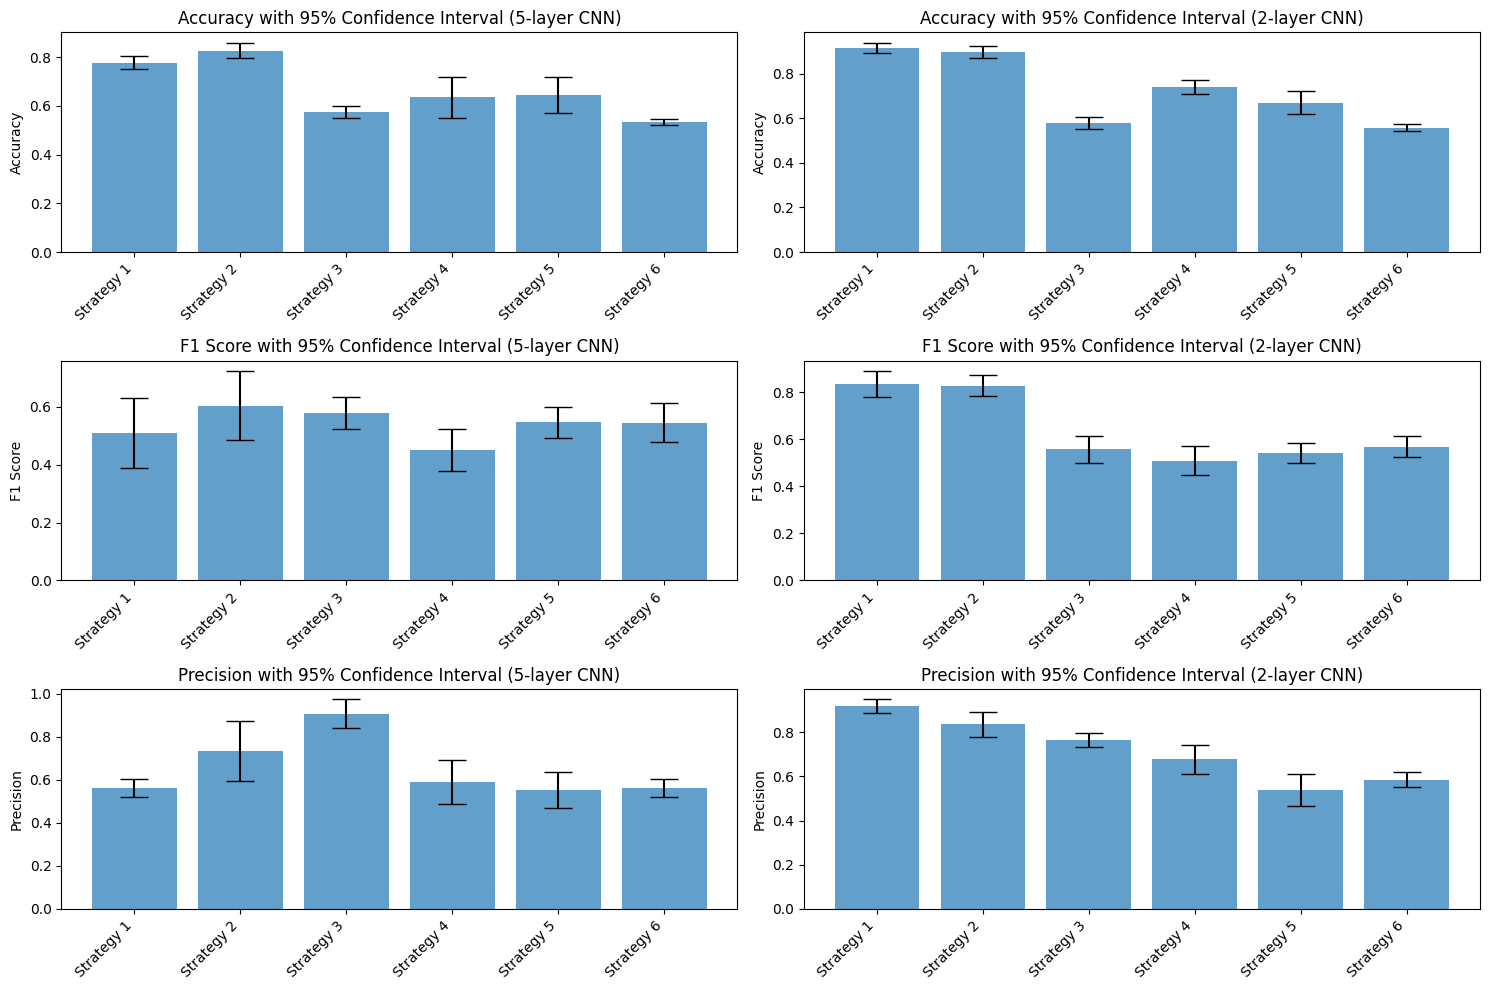

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for each model (5-layer CNN)
Strategy5 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]


# Accuracy data for each model (5-layer CNN)
accuracies5 = [[0.7500, 0.7679, 0.8839, 0.9018, 0.8304, 0.7207, 0.7748, 0.8018, 0.7477, 0.7748,
                            0.8108, 0.7477, 0.7207, 0.7387, 0.7297, 0.7387, 0.8108, 0.8378, 0.8288, 0.8919,
                            0.8649, 0.6937, 0.6937, 0.6937, 0.6937],
    [0.7500, 0.7500, 0.8929, 0.6875, 0.8304, 0.7207, 0.7207, 0.8559, 0.8649, 0.7207,
                            0.7387, 0.7838, 0.7748, 0.8018, 0.9550, 0.8378, 0.7658, 0.9099, 0.9459, 0.8739,
                            0.9009, 0.8378, 0.9099, 0.9279, 0.9279],
    [0.5312, 0.5312, 0.5938, 0.5062, 0.5563, 0.4717, 0.6855, 0.5283, 0.4969, 0.5975,
                            0.5031, 0.6478, 0.6415, 0.5409, 0.6792, 0.6289, 0.5975, 0.6352, 0.5597, 0.6289,
                            0.5786, 0.6730, 0.5283, 0.5283, 0.5094],
    [0.7528, 0.7865, 0.7169, 0.7146, 0.8404, 0.4607, 0.7888, 0.2787, 0.7685, 0.7236,
                            0.7596, 0.7303, 0.8382, 0.8000, 0.2809, 0.3191, 0.3213, 0.7236, 0.7978, 0.8449,
                            0.2950, 0.7072, 0.4234, 0.8604, 0.3536],
    [0.7618, 0.7483, 0.7146, 0.8292, 0.6966, 0.3169, 0.3573, 0.7865, 0.5483, 0.8045,
                            0.6247, 0.8292, 0.5708, 0.4067, 0.8360, 0.8629, 0.6449, 0.5124, 0.8719, 0.4494,
                            0.7703, 0.3108, 0.3131, 0.8176, 0.7275],
    [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079],
]

# F1 scores data for each model (5-layer CNN)
f1_scores5 = [
    [ 0.6389, 0.7347, 0.7660, 0.7164, 0.0606, 0.6032, 0.5600, 0.2222, 0.4681, 0.5116,
                  0.0667,  0.2927, 0.5714, 0.6538, 0.6545, 0.8378, 0.7692,0.0556],
    [0.7500, 0.5977, 0.4865, 0.0606, 0.0606, 0.7949, 0.6939, 0.0606,
                  0.5000, 0.2424, 0.4211, 0.9123, 0.6538, 0.4091, 0.8333, 0.9118, 0.7500, 0.8070,
                  0.7805, 0.8438, 0.8667, 0.8667],
    [0.6939, 0.6939, 0.6632, 0.1319, 0.6502, 0.6283, 0.5000, 0.6479, 0.6296, 0.2195,
                  0.6030, 0.4286, 0.4865, 0.6178, 0.5920, 0.6289, 0.5077, 0.5972, 0.7131, 0.7489,
                  0.5988, 0.6119, 0.6231, 0.6114, 0.6355],
   [0.3678, 0.5887, 0.6500, 0.1806, 0.7078, 0.4937, 0.3974, 0.4278, 0.2993,
                  0.2302, 0.0625, 0.6364, 0.4258, 0.4203, 0.4656, 0.4664, 0.1633, 0.4944, 0.7294,
                  0.4538, 0.5039, 0.7304, 0.4753],
    [0.4536, 0.6543, 0.1361, 0.6885, 0.5545, 0.4391, 0.4500, 0.6122, 0.5336, 0.5672,
                  0.5751, 0.6042, 0.5375, 0.4656, 0.6218, 0.7550, 0.6108, 0.5489, 0.8068, 0.5168,
                  0.3625, 0.4594, 0.4583, 0.5930, 0.6667],
     [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]
]

# Precision data for each model (5-layer CNN)
precisions5 = [
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000],
    [0.5227, 0.8571, 0.9474, 0.6154, 1.0000, 0.6129, 0.7778, 1.0000, 0.7333, 0.7857,
                   1.0000, 0.0000,  0.0000,  1.0000, 1.0000, 1.0000, 0.7949, 0.8065,  0.5000],
    [0.9000, 0.4407, 1.0000, 1.0000, 1.0000, 0.6739, 1.0000, 1.0000,
                   0.6316, 1.0000, 0.8889, 0.9286, 1.0000, 1.0000, 1.0000, 0.9394, 1.0000,
                   1.0000, 0.6667, 0.9000, 1.0000, 1.0000],
    [0.8000, 0.7010, 0.5177, 0.6667, 0.7890, 0.3305, 0.8611, 0.2721, 0.8148,
                   0.6957, 0.3333, 0.7683, 0.8462, 0.2661, 0.3034, 0.3041, 0.8000, 0.9565, 0.7561,
                   0.2935, 0.3368, 0.8400, 0.3118],
    [0.7333, 0.5579, 0.7692, 0.7636, 0.4970, 0.2820, 0.2925, 0.6000, 0.3698, 0.7037,
                   0.4079, 0.7632, 0.3737, 0.3042, 0.7792, 0.8034, 0.4526, 0.3782, 0.7301, 0.3493,
                   0.9667, 0.2982, 0.2979, 0.8551, 0.5193],
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]
]

# Define the data for each model (2-layer CNN)
Strategy2 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]



# Accuracy data for each model (2-layer CNN)
accuracies2 = [
    [0.7589, 0.8571, 0.8482, 0.9018, 0.8661, 0.9279, 0.9009, 0.7117, 0.9189, 0.8288,
     0.8018, 0.9009, 0.9279, 0.9279, 0.9550, 0.9730, 0.7568, 0.9730, 0.9730, 0.9459,
     0.8018, 0.9640, 0.8649, 0.9459, 0.9009, 0.9286, 0.9375, 0.7500, 0.7500, 0.9196,
     0.7928, 0.9910, 0.9640, 0.9369, 0.9640, 0.9009, 1.0000, 1.0000, 0.9730, 0.9730,
     1.0000, 0.9820, 0.9910, 1.0000, 0.9910, 0.9820, 0.9640, 0.9730, 1.0000, 0.9910],
    [0.7500, 0.8393, 0.8571, 0.8929, 0.8839, 0.9640, 0.9459, 0.8108, 0.9009, 0.9099,
     0.9189, 0.9910, 0.8739, 0.9189, 0.8739, 0.9369, 0.9730, 0.9640, 0.9550, 0.7477,
     0.7748, 0.9279, 0.8468, 0.9730, 0.9369],
    [0.4813, 0.5000, 0.5250, 0.5125, 0.5125, 0.7358, 0.5031, 0.6667, 0.6289, 0.6415,
     0.6604, 0.4906, 0.4969, 0.5472, 0.5723, 0.5723, 0.6101, 0.5723, 0.5472, 0.6352,
     0.5283, 0.6792, 0.6289, 0.5723, 0.6226],
    [0.7281, 0.6921, 0.7618, 0.4764, 0.7596, 0.7551, 0.7663, 0.8045, 0.7955, 0.7258,
     0.7978, 0.7326, 0.7798, 0.4944, 0.7640, 0.8000, 0.7169, 0.8270, 0.6854, 0.8090,
     0.7933, 0.7034, 0.7393, 0.8067, 0.7573, 0.7838, 0.8018, 0.5698, 0.8041, 0.7703],
    [0.6809, 0.6719, 0.7640, 0.6764, 0.8112, 0.5438, 0.7281, 0.7079, 0.7281, 0.7303,
     0.6000, 0.5393, 0.7865, 0.8202, 0.4135, 0.6854, 0.3978, 0.7393, 0.7371, 0.6876,
     0.4212, 0.8131, 0.7342, 0.5045, 0.8153],
    [0.5181, 0.5636, 0.5479, 0.5228, 0.5746, 0.5699, 0.5196, 0.5306, 0.5338, 0.5165,
     0.4961, 0.5950, 0.5808, 0.5808, 0.6170, 0.5243, 0.4961, 0.6264, 0.4867, 0.6232,
     0.5676, 0.6085, 0.5881, 0.5755, 0.5645]
]

# F1 scores data for each model (2-layer CNN)
f1_scores2 =[
    [0.0690, 0.6000, 0.6047, 0.7843, 0.6939, 0.8621, 0.8197, 0.6667, 0.8732, 0.6667,
     0.3889, 0.7843, 0.8750, 0.8788, 0.9123, 0.9589, 0.3721, 0.9589, 0.9589, 0.9167,
     0.5217, 0.9444, 0.7170, 0.9091, 0.8070, 0.7660, 1.0000, 0.8085, 0.7356,
     0.9846, 0.9394, 0.9014, 0.9412, 0.7660, 1.0000, 1.0000, 0.9455, 0.9508, 1.0000,
     0.9714, 0.9859, 1.0000, 0.9859, 0.9697, 0.9375, 0.9565, 1.0000, 0.9851],
    [ 0.5500, 0.7143, 0.7500, 0.7347, 0.9412, 0.9091, 0.7470, 0.7925, 0.8571,
     0.8163, 0.9831, 0.8056, 0.8657, 0.8056, 0.9091, 0.9589, 0.9459, 0.9333, 0.7143,
     0.7312, 0.8889, 0.6667, 0.9538, 0.8923],
    [0.4276, 0.6581, 0.5476, 0.3607, 0.5465, 0.6957, 0.6457, 0.5310, 0.5354, 0.3871,
     0.6351, 0.6368, 0.6330, 0.6211, 0.1053, 0.3929, 0.6702, 0.7236, 0.3455, 0.7010,
     0.6809, 0.6222, 0.6550, 0.6495, 0.5385],
    [0.2390, 0.5959, 0.4904, 0.5176, 0.6537, 0.3842, 0.4023, 0.5714, 0.5845, 0.1974,
     0.5794, 0.0165, 0.3288, 0.5119, 0.6237, 0.6787, 0.5855, 0.6280, 0.5977, 0.5304,
     0.5965, 0.2368, 0.6091, 0.6766, 0.4667, 0.5269, 0.5609, 0.7031, 0.6813],
    [0.4132, 0.5731, 0.4444, 0.6108, 0.7000, 0.5201, 0.6109, 0.5455, 0.6207, 0.5946,
     0.5436, 0.5176, 0.3357, 0.6330, 0.4641, 0.6067, 0.4866, 0.6548, 0.2041, 0.5413,
     0.5010, 0.6407, 0.6424, 0.5359, 0.5729],
    [0.6785, 0.5959, 0.5119, 0.6398, 0.6272, 0.5798, 0.6786, 0.6849, 0.6890, 0.3156,
     0.6596, 0.6043, 0.6255, 0.4540, 0.5719, 0.6576, 0.6429, 0.5980, 0.6426, 0.5572,
     0.5974, 0.4354, 0.3732, 0.5673, 0.2452]
]


# Precision data for each model (2-layer CNN)
precisions2 = [
    [1.0000, 1.0000, 0.8667, 0.8696, 0.8095, 0.9615, 0.8621, 0.5000, 0.7949, 0.7600,
     1.0000, 0.9091, 0.8000, 0.7838, 0.9286, 0.9211, 1.0000, 0.9211, 0.9211, 0.8919,
     1.0000, 0.8947, 1.0000, 0.9375, 1.0000, 0.8333, 1.0000, 1.0000, 0.5818,
     0.9697, 0.9118, 0.8205, 0.8889, 1.0000, 1.0000, 1.0000, 1.0000, 0.9722, 0.9412,
     1.0000, 1.0000, 0.9714, 0.9722, 1.0000, 1.0000, 1.0000, 0.9722],
    [ 0.9167, 0.7143, 0.9000, 0.8571, 0.8889, 0.8824, 0.6078, 1.0000, 0.7895,
     1.0000, 0.9667, 0.6744, 0.7632, 0.6744, 0.8333, 0.9211, 0.8974, 0.8750, 0.5556,
     0.5763, 0.8421, 1.0000, 1.0000, 0.9355],
    [ 0.7167, 0.7161, 0.7882, 0.7675, 0.7465, 0.6890, 0.7706, 0.7687, 0.7157,
     0.7527, 0.7700, 0.7737, 0.7469, 1.0000, 0.7266, 0.7441, 0.7817, 0.9951, 0.7266,
     0.7213, 0.7889, 0.7279, 0.7611, 0.6920],
    [0.7600, 0.4927, 0.6892, 0.3582, 0.5771, 0.7907, 0.8750, 0.8406, 0.7529, 0.8333,
     0.6596, 1.0000, 0.9231, 0.3460, 0.5472, 0.5839, 0.4734, 0.7143, 0.4483, 0.7385,
     0.7083,  0.9000, 0.7614, 0.5594, 0.8400, 0.8750, 0.4000, 0.6319, 0.5737],
    [0.4630, 0.4712, 0.7636, 0.4788, 0.6712, 0.3630, 0.4974, 0.4699, 0.4975, 0.5000,
     0.3869, 0.3560, 0.8889, 0.6765, 0.3046, 0.4821, 0.3256, 0.5392, 1.0000, 0.4795,
     0.3351, 0.7327, 0.5300, 0.3692, 0.8871],
    [0.5151, 0.5663, 0.5720, 0.5212, 0.5686, 0.5962, 0.5235, 0.5293, 0.5306, 0.6174,
     0.4937, 0.5811, 0.5575, 0.6307, 0.6342, 0.5017, 0.4865, 0.6167, 0.4820, 0.6371,
     0.5514, 0.7500, 0.7429, 0.5691, 0.8333]
]

# Calculate the mean and standard error for each model (5-layer CNN)
mean_accuracies5 = [np.mean(acc) for acc in accuracies5]
std_err_accuracies5 = [1.96 * np.std(acc, ddof=1) / np.sqrt(len(acc)) for acc in accuracies5]

mean_f1_scores5 = [np.mean(f1) for f1 in f1_scores5]
std_err_f1_scores5 = [1.96 * np.std(f1, ddof=1) / np.sqrt(len(f1)) for f1 in f1_scores5]

mean_precisions5 = [np.mean(precision) for precision in precisions5]
std_err_precisions5 = [1.96 * np.std(precision, ddof=1) / np.sqrt(len(precision)) for precision in precisions5]

# Calculate the mean and standard error for each model (2-layer CNN)
mean_accuracies2 = [np.mean(acc) for acc in accuracies2]
std_err_accuracies2 = [1.96 * np.std(acc, ddof=1) / np.sqrt(len(acc)) for acc in accuracies2]

mean_f1_scores2 = [np.mean(f1) for f1 in f1_scores2]
std_err_f1_scores2 = [1.96 * np.std(f1, ddof=1) / np.sqrt(len(f1)) for f1 in f1_scores2]

mean_precisions2 = [np.mean(precision) for precision in precisions2]
std_err_precisions2 = [1.96 * np.std(precision, ddof=1) / np.sqrt(len(precision)) for precision in precisions2]

# Create x-values for the strategies (1, 2, 3, 4, 5, 6)
x = np.arange(6)

# Create subplots for accuracy, F1 score, and precision
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plot accuracy with confidence intervals for 5-layer CNN
axs[0, 0].bar(x, mean_accuracies5, yerr=std_err_accuracies5, align='center', alpha=0.7, capsize=10)
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Accuracy with 95% Confidence Interval (5-layer CNN)')

# Plot F1 score with confidence intervals for 5-layer CNN
axs[1, 0].bar(x, mean_f1_scores5, yerr=std_err_f1_scores5, align='center', alpha=0.7, capsize=10)
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].set_title('F1 Score with 95% Confidence Interval (5-layer CNN)')

# Plot precision with confidence intervals for 5-layer CNN
axs[2, 0].bar(x, mean_precisions5, yerr=std_err_precisions5, align='center', alpha=0.7, capsize=10)
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[2, 0].set_ylabel('Precision')
axs[2, 0].set_title('Precision with 95% Confidence Interval (5-layer CNN)')

# Plot accuracy with confidence intervals for 2-layer CNN
axs[0, 1].bar(x, mean_accuracies2, yerr=std_err_accuracies2, align='center', alpha=0.7, capsize=10)
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Accuracy with 95% Confidence Interval (2-layer CNN)')

# Plot F1 score with confidence intervals for 2-layer CNN
axs[1, 1].bar(x, mean_f1_scores2, yerr=std_err_f1_scores2, align='center', alpha=0.7, capsize=10)
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].set_title('F1 Score with 95% Confidence Interval (2-layer CNN)')

# Plot precision with confidence intervals for 2-layer CNN
axs[2, 1].bar(x, mean_precisions2, yerr=std_err_precisions2, align='center', alpha=0.7, capsize=10)
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_title('Precision with 95% Confidence Interval (2-layer CNN)')

# Add some spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

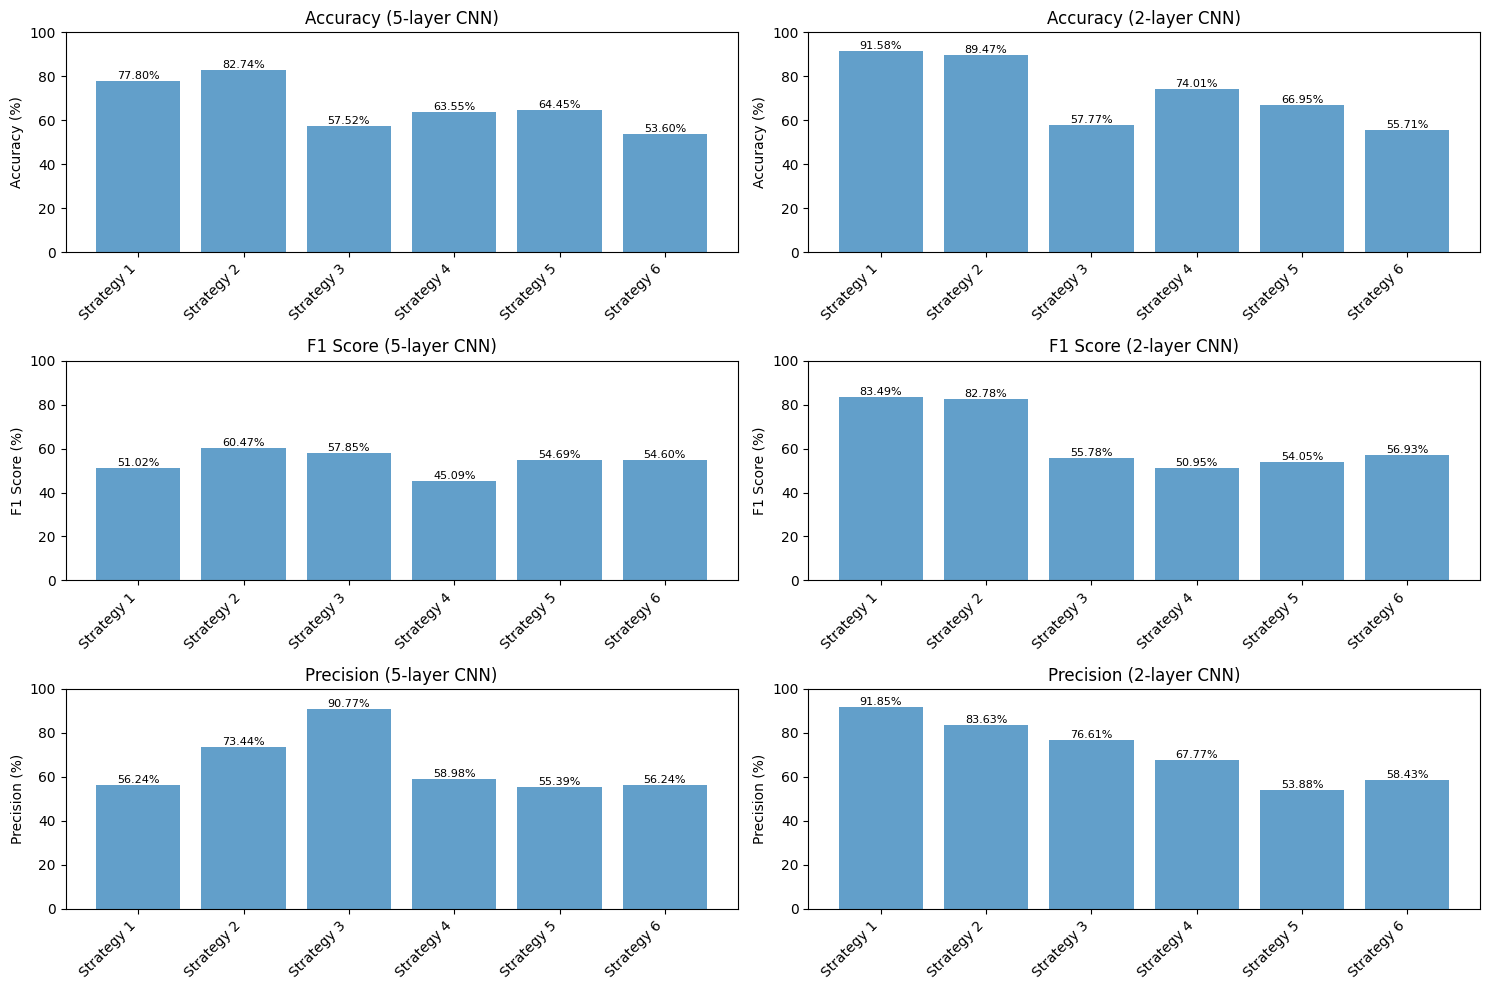

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for each model (5-layer CNN)
Strategy5 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]


# Accuracy data for each model (5-layer CNN)
accuracies5 = [[0.7500, 0.7679, 0.8839, 0.9018, 0.8304, 0.7207, 0.7748, 0.8018, 0.7477, 0.7748,
                            0.8108, 0.7477, 0.7207, 0.7387, 0.7297, 0.7387, 0.8108, 0.8378, 0.8288, 0.8919,
                            0.8649, 0.6937, 0.6937, 0.6937, 0.6937],
    [0.7500, 0.7500, 0.8929, 0.6875, 0.8304, 0.7207, 0.7207, 0.8559, 0.8649, 0.7207,
                            0.7387, 0.7838, 0.7748, 0.8018, 0.9550, 0.8378, 0.7658, 0.9099, 0.9459, 0.8739,
                            0.9009, 0.8378, 0.9099, 0.9279, 0.9279],
    [0.5312, 0.5312, 0.5938, 0.5062, 0.5563, 0.4717, 0.6855, 0.5283, 0.4969, 0.5975,
                            0.5031, 0.6478, 0.6415, 0.5409, 0.6792, 0.6289, 0.5975, 0.6352, 0.5597, 0.6289,
                            0.5786, 0.6730, 0.5283, 0.5283, 0.5094],
    [0.7528, 0.7865, 0.7169, 0.7146, 0.8404, 0.4607, 0.7888, 0.2787, 0.7685, 0.7236,
                            0.7596, 0.7303, 0.8382, 0.8000, 0.2809, 0.3191, 0.3213, 0.7236, 0.7978, 0.8449,
                            0.2950, 0.7072, 0.4234, 0.8604, 0.3536],
    [0.7618, 0.7483, 0.7146, 0.8292, 0.6966, 0.3169, 0.3573, 0.7865, 0.5483, 0.8045,
                            0.6247, 0.8292, 0.5708, 0.4067, 0.8360, 0.8629, 0.6449, 0.5124, 0.8719, 0.4494,
                            0.7703, 0.3108, 0.3131, 0.8176, 0.7275],
    [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079],
]

# F1 scores data for each model (5-layer CNN)
f1_scores5 = [
    [ 0.6389, 0.7347, 0.7660, 0.7164, 0.0606, 0.6032, 0.5600, 0.2222, 0.4681, 0.5116,
                  0.0667,  0.2927, 0.5714, 0.6538, 0.6545, 0.8378, 0.7692,0.0556],
    [0.7500, 0.5977, 0.4865, 0.0606, 0.0606, 0.7949, 0.6939, 0.0606,
                  0.5000, 0.2424, 0.4211, 0.9123, 0.6538, 0.4091, 0.8333, 0.9118, 0.7500, 0.8070,
                  0.7805, 0.8438, 0.8667, 0.8667],
    [0.6939, 0.6939, 0.6632, 0.1319, 0.6502, 0.6283, 0.5000, 0.6479, 0.6296, 0.2195,
                  0.6030, 0.4286, 0.4865, 0.6178, 0.5920, 0.6289, 0.5077, 0.5972, 0.7131, 0.7489,
                  0.5988, 0.6119, 0.6231, 0.6114, 0.6355],
   [0.3678, 0.5887, 0.6500, 0.1806, 0.7078, 0.4937, 0.3974, 0.4278, 0.2993,
                  0.2302, 0.0625, 0.6364, 0.4258, 0.4203, 0.4656, 0.4664, 0.1633, 0.4944, 0.7294,
                  0.4538, 0.5039, 0.7304, 0.4753],
    [0.4536, 0.6543, 0.1361, 0.6885, 0.5545, 0.4391, 0.4500, 0.6122, 0.5336, 0.5672,
                  0.5751, 0.6042, 0.5375, 0.4656, 0.6218, 0.7550, 0.6108, 0.5489, 0.8068, 0.5168,
                  0.3625, 0.4594, 0.4583, 0.5930, 0.6667],
     [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]
]

# Precision data for each model (5-layer CNN)
precisions5 = [
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000],
    [0.5227, 0.8571, 0.9474, 0.6154, 1.0000, 0.6129, 0.7778, 1.0000, 0.7333, 0.7857,
                   1.0000, 0.0000,  0.0000,  1.0000, 1.0000, 1.0000, 0.7949, 0.8065,  0.5000],
    [0.9000, 0.4407, 1.0000, 1.0000, 1.0000, 0.6739, 1.0000, 1.0000,
                   0.6316, 1.0000, 0.8889, 0.9286, 1.0000, 1.0000, 1.0000, 0.9394, 1.0000,
                   1.0000, 0.6667, 0.9000, 1.0000, 1.0000],
    [0.8000, 0.7010, 0.5177, 0.6667, 0.7890, 0.3305, 0.8611, 0.2721, 0.8148,
                   0.6957, 0.3333, 0.7683, 0.8462, 0.2661, 0.3034, 0.3041, 0.8000, 0.9565, 0.7561,
                   0.2935, 0.3368, 0.8400, 0.3118],
    [0.7333, 0.5579, 0.7692, 0.7636, 0.4970, 0.2820, 0.2925, 0.6000, 0.3698, 0.7037,
                   0.4079, 0.7632, 0.3737, 0.3042, 0.7792, 0.8034, 0.4526, 0.3782, 0.7301, 0.3493,
                   0.9667, 0.2982, 0.2979, 0.8551, 0.5193],
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]
]

# Define the data for each model (2-layer CNN)
Strategy2 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]



# Accuracy data for each model (2-layer CNN)
accuracies2 = [
    [0.7589, 0.8571, 0.8482, 0.9018, 0.8661, 0.9279, 0.9009, 0.7117, 0.9189, 0.8288,
     0.8018, 0.9009, 0.9279, 0.9279, 0.9550, 0.9730, 0.7568, 0.9730, 0.9730, 0.9459,
     0.8018, 0.9640, 0.8649, 0.9459, 0.9009, 0.9286, 0.9375, 0.7500, 0.7500, 0.9196,
     0.7928, 0.9910, 0.9640, 0.9369, 0.9640, 0.9009, 1.0000, 1.0000, 0.9730, 0.9730,
     1.0000, 0.9820, 0.9910, 1.0000, 0.9910, 0.9820, 0.9640, 0.9730, 1.0000, 0.9910],
    [0.7500, 0.8393, 0.8571, 0.8929, 0.8839, 0.9640, 0.9459, 0.8108, 0.9009, 0.9099,
     0.9189, 0.9910, 0.8739, 0.9189, 0.8739, 0.9369, 0.9730, 0.9640, 0.9550, 0.7477,
     0.7748, 0.9279, 0.8468, 0.9730, 0.9369],
    [0.4813, 0.5000, 0.5250, 0.5125, 0.5125, 0.7358, 0.5031, 0.6667, 0.6289, 0.6415,
     0.6604, 0.4906, 0.4969, 0.5472, 0.5723, 0.5723, 0.6101, 0.5723, 0.5472, 0.6352,
     0.5283, 0.6792, 0.6289, 0.5723, 0.6226],
    [0.7281, 0.6921, 0.7618, 0.4764, 0.7596, 0.7551, 0.7663, 0.8045, 0.7955, 0.7258,
     0.7978, 0.7326, 0.7798, 0.4944, 0.7640, 0.8000, 0.7169, 0.8270, 0.6854, 0.8090,
     0.7933, 0.7034, 0.7393, 0.8067, 0.7573, 0.7838, 0.8018, 0.5698, 0.8041, 0.7703],
    [0.6809, 0.6719, 0.7640, 0.6764, 0.8112, 0.5438, 0.7281, 0.7079, 0.7281, 0.7303,
     0.6000, 0.5393, 0.7865, 0.8202, 0.4135, 0.6854, 0.3978, 0.7393, 0.7371, 0.6876,
     0.4212, 0.8131, 0.7342, 0.5045, 0.8153],
    [0.5181, 0.5636, 0.5479, 0.5228, 0.5746, 0.5699, 0.5196, 0.5306, 0.5338, 0.5165,
     0.4961, 0.5950, 0.5808, 0.5808, 0.6170, 0.5243, 0.4961, 0.6264, 0.4867, 0.6232,
     0.5676, 0.6085, 0.5881, 0.5755, 0.5645]
]

# F1 scores data for each model (2-layer CNN)
f1_scores2 =[
    [0.0690, 0.6000, 0.6047, 0.7843, 0.6939, 0.8621, 0.8197, 0.6667, 0.8732, 0.6667,
     0.3889, 0.7843, 0.8750, 0.8788, 0.9123, 0.9589, 0.3721, 0.9589, 0.9589, 0.9167,
     0.5217, 0.9444, 0.7170, 0.9091, 0.8070, 0.7660, 1.0000, 0.8085, 0.7356,
     0.9846, 0.9394, 0.9014, 0.9412, 0.7660, 1.0000, 1.0000, 0.9455, 0.9508, 1.0000,
     0.9714, 0.9859, 1.0000, 0.9859, 0.9697, 0.9375, 0.9565, 1.0000, 0.9851],
    [ 0.5500, 0.7143, 0.7500, 0.7347, 0.9412, 0.9091, 0.7470, 0.7925, 0.8571,
     0.8163, 0.9831, 0.8056, 0.8657, 0.8056, 0.9091, 0.9589, 0.9459, 0.9333, 0.7143,
     0.7312, 0.8889, 0.6667, 0.9538, 0.8923],
    [0.4276, 0.6581, 0.5476, 0.3607, 0.5465, 0.6957, 0.6457, 0.5310, 0.5354, 0.3871,
     0.6351, 0.6368, 0.6330, 0.6211, 0.1053, 0.3929, 0.6702, 0.7236, 0.3455, 0.7010,
     0.6809, 0.6222, 0.6550, 0.6495, 0.5385],
    [0.2390, 0.5959, 0.4904, 0.5176, 0.6537, 0.3842, 0.4023, 0.5714, 0.5845, 0.1974,
     0.5794, 0.0165, 0.3288, 0.5119, 0.6237, 0.6787, 0.5855, 0.6280, 0.5977, 0.5304,
     0.5965, 0.2368, 0.6091, 0.6766, 0.4667, 0.5269, 0.5609, 0.7031, 0.6813],
    [0.4132, 0.5731, 0.4444, 0.6108, 0.7000, 0.5201, 0.6109, 0.5455, 0.6207, 0.5946,
     0.5436, 0.5176, 0.3357, 0.6330, 0.4641, 0.6067, 0.4866, 0.6548, 0.2041, 0.5413,
     0.5010, 0.6407, 0.6424, 0.5359, 0.5729],
    [0.6785, 0.5959, 0.5119, 0.6398, 0.6272, 0.5798, 0.6786, 0.6849, 0.6890, 0.3156,
     0.6596, 0.6043, 0.6255, 0.4540, 0.5719, 0.6576, 0.6429, 0.5980, 0.6426, 0.5572,
     0.5974, 0.4354, 0.3732, 0.5673, 0.2452]
]


# Precision data for each model (2-layer CNN)
precisions2 = [
    [1.0000, 1.0000, 0.8667, 0.8696, 0.8095, 0.9615, 0.8621, 0.5000, 0.7949, 0.7600,
     1.0000, 0.9091, 0.8000, 0.7838, 0.9286, 0.9211, 1.0000, 0.9211, 0.9211, 0.8919,
     1.0000, 0.8947, 1.0000, 0.9375, 1.0000, 0.8333, 1.0000, 1.0000, 0.5818,
     0.9697, 0.9118, 0.8205, 0.8889, 1.0000, 1.0000, 1.0000, 1.0000, 0.9722, 0.9412,
     1.0000, 1.0000, 0.9714, 0.9722, 1.0000, 1.0000, 1.0000, 0.9722],
    [ 0.9167, 0.7143, 0.9000, 0.8571, 0.8889, 0.8824, 0.6078, 1.0000, 0.7895,
     1.0000, 0.9667, 0.6744, 0.7632, 0.6744, 0.8333, 0.9211, 0.8974, 0.8750, 0.5556,
     0.5763, 0.8421, 1.0000, 1.0000, 0.9355],
    [ 0.7167, 0.7161, 0.7882, 0.7675, 0.7465, 0.6890, 0.7706, 0.7687, 0.7157,
     0.7527, 0.7700, 0.7737, 0.7469, 1.0000, 0.7266, 0.7441, 0.7817, 0.9951, 0.7266,
     0.7213, 0.7889, 0.7279, 0.7611, 0.6920],
    [0.7600, 0.4927, 0.6892, 0.3582, 0.5771, 0.7907, 0.8750, 0.8406, 0.7529, 0.8333,
     0.6596, 1.0000, 0.9231, 0.3460, 0.5472, 0.5839, 0.4734, 0.7143, 0.4483, 0.7385,
     0.7083,  0.9000, 0.7614, 0.5594, 0.8400, 0.8750, 0.4000, 0.6319, 0.5737],
    [0.4630, 0.4712, 0.7636, 0.4788, 0.6712, 0.3630, 0.4974, 0.4699, 0.4975, 0.5000,
     0.3869, 0.3560, 0.8889, 0.6765, 0.3046, 0.4821, 0.3256, 0.5392, 1.0000, 0.4795,
     0.3351, 0.7327, 0.5300, 0.3692, 0.8871],
    [0.5151, 0.5663, 0.5720, 0.5212, 0.5686, 0.5962, 0.5235, 0.5293, 0.5306, 0.6174,
     0.4937, 0.5811, 0.5575, 0.6307, 0.6342, 0.5017, 0.4865, 0.6167, 0.4820, 0.6371,
     0.5514, 0.7500, 0.7429, 0.5691, 0.8333]
]

# Calculate the mean for each model (5-layer CNN)
mean_accuracies5 = [np.mean(acc) * 100 for acc in accuracies5]
mean_f1_scores5 = [np.mean(f1) * 100 for f1 in f1_scores5]
mean_precisions5 = [np.mean(precision) * 100 for precision in precisions5]

# Calculate the mean for each model (2-layer CNN)
mean_accuracies2 = [np.mean(acc) * 100 for acc in accuracies2]
mean_f1_scores2 = [np.mean(f1) * 100 for f1 in f1_scores2]
mean_precisions2 = [np.mean(precision) * 100 for precision in precisions2]

# Create x-values for the strategies (1, 2, 3, 4, 5, 6)
x = np.arange(6)

# Create subplots for accuracy, F1 score, and precision
fig, axs = plt.subplots(3, 2, figsize=(15, 10))


# Plot accuracy for 5-layer CNN
bars = axs[0, 0].bar(x, mean_accuracies5, align='center', alpha=0.7, capsize=10)
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[0, 0].set_ylabel('Accuracy (%)')
axs[0, 0].set_title('Accuracy (5-layer CNN)')
axs[0, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot F1 score for 5-layer CNN
bars = axs[1, 0].bar(x, mean_f1_scores5, align='center', alpha=0.7, capsize=10)
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[1, 0].set_ylabel('F1 Score (%)')
axs[1, 0].set_title('F1 Score (5-layer CNN)')
axs[1, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot precision for 5-layer CNN
bars = axs[2, 0].bar(x, mean_precisions5, align='center', alpha=0.7, capsize=10)
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(Strategy5, rotation=45, ha='right')
axs[2, 0].set_ylabel('Precision (%)')
axs[2, 0].set_title('Precision (5-layer CNN)')
axs[2, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot accuracy for 2-layer CNN
bars = axs[0, 1].bar(x, mean_accuracies2, align='center', alpha=0.7, capsize=10)
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].set_title('Accuracy (2-layer CNN)')
axs[0, 1].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot F1 score for 2-layer CNN
bars = axs[1, 1].bar(x, mean_f1_scores2, align='center', alpha=0.7, capsize=10)
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[1, 1].set_ylabel('F1 Score (%)')
axs[1, 1].set_title('F1 Score (2-layer CNN)')
axs[1, 1].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot precision for 2-layer CNN
bars = axs[2, 1].bar(x, mean_precisions2, align='center', alpha=0.7, capsize=10)
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(Strategy2, rotation=45, ha='right')
axs[2, 1].set_ylabel('Precision (%)')
axs[2, 1].set_title('Precision (2-layer CNN)')
axs[2, 1].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Add the percentages on top of the bars
def add_bar_percentages(ax):
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)

add_bar_percentages(axs[0, 0])
add_bar_percentages(axs[1, 0])
add_bar_percentages(axs[2, 0])
add_bar_percentages(axs[0, 1])
add_bar_percentages(axs[1, 1])
add_bar_percentages(axs[2, 1])

# Add some spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

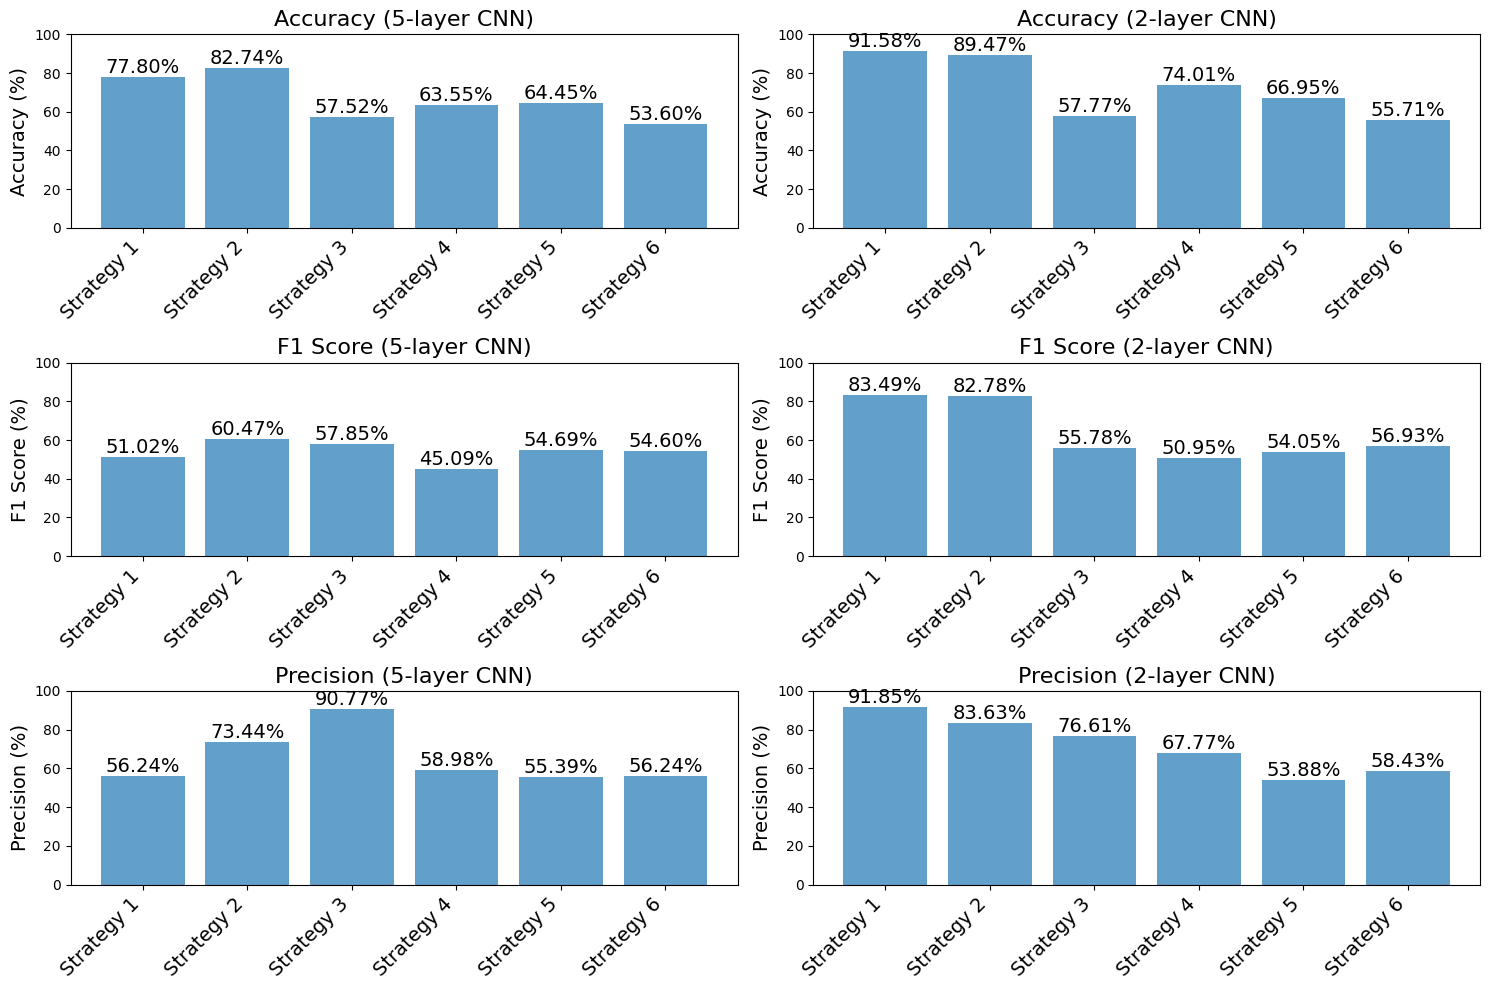

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for each model (5-layer CNN)
Strategy5 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]


# Accuracy data for each model (5-layer CNN)
accuracies5 = [[0.7500, 0.7679, 0.8839, 0.9018, 0.8304, 0.7207, 0.7748, 0.8018, 0.7477, 0.7748,
                            0.8108, 0.7477, 0.7207, 0.7387, 0.7297, 0.7387, 0.8108, 0.8378, 0.8288, 0.8919,
                            0.8649, 0.6937, 0.6937, 0.6937, 0.6937],
    [0.7500, 0.7500, 0.8929, 0.6875, 0.8304, 0.7207, 0.7207, 0.8559, 0.8649, 0.7207,
                            0.7387, 0.7838, 0.7748, 0.8018, 0.9550, 0.8378, 0.7658, 0.9099, 0.9459, 0.8739,
                            0.9009, 0.8378, 0.9099, 0.9279, 0.9279],
    [0.5312, 0.5312, 0.5938, 0.5062, 0.5563, 0.4717, 0.6855, 0.5283, 0.4969, 0.5975,
                            0.5031, 0.6478, 0.6415, 0.5409, 0.6792, 0.6289, 0.5975, 0.6352, 0.5597, 0.6289,
                            0.5786, 0.6730, 0.5283, 0.5283, 0.5094],
    [0.7528, 0.7865, 0.7169, 0.7146, 0.8404, 0.4607, 0.7888, 0.2787, 0.7685, 0.7236,
                            0.7596, 0.7303, 0.8382, 0.8000, 0.2809, 0.3191, 0.3213, 0.7236, 0.7978, 0.8449,
                            0.2950, 0.7072, 0.4234, 0.8604, 0.3536],
    [0.7618, 0.7483, 0.7146, 0.8292, 0.6966, 0.3169, 0.3573, 0.7865, 0.5483, 0.8045,
                            0.6247, 0.8292, 0.5708, 0.4067, 0.8360, 0.8629, 0.6449, 0.5124, 0.8719, 0.4494,
                            0.7703, 0.3108, 0.3131, 0.8176, 0.7275],
    [0.5714, 0.4867, 0.5353, 0.5118, 0.5369, 0.5322, 0.5620, 0.5903, 0.5934, 0.5416,
                            0.5385, 0.5196, 0.5463, 0.5777, 0.5871, 0.5495, 0.5510, 0.5416, 0.4992, 0.5228,
                            0.4906, 0.4921, 0.5220, 0.4921, 0.5079],
]

# F1 scores data for each model (5-layer CNN)
f1_scores5 = [
    [ 0.6389, 0.7347, 0.7660, 0.7164, 0.0606, 0.6032, 0.5600, 0.2222, 0.4681, 0.5116,
                  0.0667,  0.2927, 0.5714, 0.6538, 0.6545, 0.8378, 0.7692,0.0556],
    [0.7500, 0.5977, 0.4865, 0.0606, 0.0606, 0.7949, 0.6939, 0.0606,
                  0.5000, 0.2424, 0.4211, 0.9123, 0.6538, 0.4091, 0.8333, 0.9118, 0.7500, 0.8070,
                  0.7805, 0.8438, 0.8667, 0.8667],
    [0.6939, 0.6939, 0.6632, 0.1319, 0.6502, 0.6283, 0.5000, 0.6479, 0.6296, 0.2195,
                  0.6030, 0.4286, 0.4865, 0.6178, 0.5920, 0.6289, 0.5077, 0.5972, 0.7131, 0.7489,
                  0.5988, 0.6119, 0.6231, 0.6114, 0.6355],
   [0.3678, 0.5887, 0.6500, 0.1806, 0.7078, 0.4937, 0.3974, 0.4278, 0.2993,
                  0.2302, 0.0625, 0.6364, 0.4258, 0.4203, 0.4656, 0.4664, 0.1633, 0.4944, 0.7294,
                  0.4538, 0.5039, 0.7304, 0.4753],
    [0.4536, 0.6543, 0.1361, 0.6885, 0.5545, 0.4391, 0.4500, 0.6122, 0.5336, 0.5672,
                  0.5751, 0.6042, 0.5375, 0.4656, 0.6218, 0.7550, 0.6108, 0.5489, 0.8068, 0.5168,
                  0.3625, 0.4594, 0.4583, 0.5930, 0.6667],
     [0.5819, 0.4700, 0.6674, 0.6771, 0.6719, 0.6689, 0.5358, 0.6709, 0.5480, 0.6386,
                  0.6316, 0.6458, 0.5285, 0.5893, 0.4463, 0.6335, 0.1829, 0.0818, 0.4639, 0.0952,
                  0.6516, 0.6596, 0.6072, 0.6423, 0.6602]
]

# Precision data for each model (5-layer CNN)
precisions5 = [
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000],
    [0.5227, 0.8571, 0.9474, 0.6154, 1.0000, 0.6129, 0.7778, 1.0000, 0.7333, 0.7857,
                   1.0000, 0.0000,  0.0000,  1.0000, 1.0000, 1.0000, 0.7949, 0.8065,  0.5000],
    [0.9000, 0.4407, 1.0000, 1.0000, 1.0000, 0.6739, 1.0000, 1.0000,
                   0.6316, 1.0000, 0.8889, 0.9286, 1.0000, 1.0000, 1.0000, 0.9394, 1.0000,
                   1.0000, 0.6667, 0.9000, 1.0000, 1.0000],
    [0.8000, 0.7010, 0.5177, 0.6667, 0.7890, 0.3305, 0.8611, 0.2721, 0.8148,
                   0.6957, 0.3333, 0.7683, 0.8462, 0.2661, 0.3034, 0.3041, 0.8000, 0.9565, 0.7561,
                   0.2935, 0.3368, 0.8400, 0.3118],
    [0.7333, 0.5579, 0.7692, 0.7636, 0.4970, 0.2820, 0.2925, 0.6000, 0.3698, 0.7037,
                   0.4079, 0.7632, 0.3737, 0.3042, 0.7792, 0.8034, 0.4526, 0.3782, 0.7301, 0.3493,
                   0.9667, 0.2982, 0.2979, 0.8551, 0.5193],
    [0.5810, 0.4983, 0.5266, 0.5118, 0.5271, 0.5327, 0.6053, 0.5808, 0.6597, 0.5455,
                   0.5196, 0.5064, 0.5400, 0.5643, 0.6543, 0.5188, 0.7111, 1.0000, 0.4759, 0.5161,
                   0.4911, 0.4921, 0.5098, 0.4915, 0.5000]
]

# Define the data for each model (2-layer CNN)
Strategy2 = ["Strategy 1",
          "Strategy 2",
          "Strategy 3",
          "Strategy 4",
          "Strategy 5",
          "Strategy 6"]



# Accuracy data for each model (2-layer CNN)
accuracies2 = [
    [0.7589, 0.8571, 0.8482, 0.9018, 0.8661, 0.9279, 0.9009, 0.7117, 0.9189, 0.8288,
     0.8018, 0.9009, 0.9279, 0.9279, 0.9550, 0.9730, 0.7568, 0.9730, 0.9730, 0.9459,
     0.8018, 0.9640, 0.8649, 0.9459, 0.9009, 0.9286, 0.9375, 0.7500, 0.7500, 0.9196,
     0.7928, 0.9910, 0.9640, 0.9369, 0.9640, 0.9009, 1.0000, 1.0000, 0.9730, 0.9730,
     1.0000, 0.9820, 0.9910, 1.0000, 0.9910, 0.9820, 0.9640, 0.9730, 1.0000, 0.9910],
    [0.7500, 0.8393, 0.8571, 0.8929, 0.8839, 0.9640, 0.9459, 0.8108, 0.9009, 0.9099,
     0.9189, 0.9910, 0.8739, 0.9189, 0.8739, 0.9369, 0.9730, 0.9640, 0.9550, 0.7477,
     0.7748, 0.9279, 0.8468, 0.9730, 0.9369],
    [0.4813, 0.5000, 0.5250, 0.5125, 0.5125, 0.7358, 0.5031, 0.6667, 0.6289, 0.6415,
     0.6604, 0.4906, 0.4969, 0.5472, 0.5723, 0.5723, 0.6101, 0.5723, 0.5472, 0.6352,
     0.5283, 0.6792, 0.6289, 0.5723, 0.6226],
    [0.7281, 0.6921, 0.7618, 0.4764, 0.7596, 0.7551, 0.7663, 0.8045, 0.7955, 0.7258,
     0.7978, 0.7326, 0.7798, 0.4944, 0.7640, 0.8000, 0.7169, 0.8270, 0.6854, 0.8090,
     0.7933, 0.7034, 0.7393, 0.8067, 0.7573, 0.7838, 0.8018, 0.5698, 0.8041, 0.7703],
    [0.6809, 0.6719, 0.7640, 0.6764, 0.8112, 0.5438, 0.7281, 0.7079, 0.7281, 0.7303,
     0.6000, 0.5393, 0.7865, 0.8202, 0.4135, 0.6854, 0.3978, 0.7393, 0.7371, 0.6876,
     0.4212, 0.8131, 0.7342, 0.5045, 0.8153],
    [0.5181, 0.5636, 0.5479, 0.5228, 0.5746, 0.5699, 0.5196, 0.5306, 0.5338, 0.5165,
     0.4961, 0.5950, 0.5808, 0.5808, 0.6170, 0.5243, 0.4961, 0.6264, 0.4867, 0.6232,
     0.5676, 0.6085, 0.5881, 0.5755, 0.5645]
]

# F1 scores data for each model (2-layer CNN)
f1_scores2 =[
    [0.0690, 0.6000, 0.6047, 0.7843, 0.6939, 0.8621, 0.8197, 0.6667, 0.8732, 0.6667,
     0.3889, 0.7843, 0.8750, 0.8788, 0.9123, 0.9589, 0.3721, 0.9589, 0.9589, 0.9167,
     0.5217, 0.9444, 0.7170, 0.9091, 0.8070, 0.7660, 1.0000, 0.8085, 0.7356,
     0.9846, 0.9394, 0.9014, 0.9412, 0.7660, 1.0000, 1.0000, 0.9455, 0.9508, 1.0000,
     0.9714, 0.9859, 1.0000, 0.9859, 0.9697, 0.9375, 0.9565, 1.0000, 0.9851],
    [ 0.5500, 0.7143, 0.7500, 0.7347, 0.9412, 0.9091, 0.7470, 0.7925, 0.8571,
     0.8163, 0.9831, 0.8056, 0.8657, 0.8056, 0.9091, 0.9589, 0.9459, 0.9333, 0.7143,
     0.7312, 0.8889, 0.6667, 0.9538, 0.8923],
    [0.4276, 0.6581, 0.5476, 0.3607, 0.5465, 0.6957, 0.6457, 0.5310, 0.5354, 0.3871,
     0.6351, 0.6368, 0.6330, 0.6211, 0.1053, 0.3929, 0.6702, 0.7236, 0.3455, 0.7010,
     0.6809, 0.6222, 0.6550, 0.6495, 0.5385],
    [0.2390, 0.5959, 0.4904, 0.5176, 0.6537, 0.3842, 0.4023, 0.5714, 0.5845, 0.1974,
     0.5794, 0.0165, 0.3288, 0.5119, 0.6237, 0.6787, 0.5855, 0.6280, 0.5977, 0.5304,
     0.5965, 0.2368, 0.6091, 0.6766, 0.4667, 0.5269, 0.5609, 0.7031, 0.6813],
    [0.4132, 0.5731, 0.4444, 0.6108, 0.7000, 0.5201, 0.6109, 0.5455, 0.6207, 0.5946,
     0.5436, 0.5176, 0.3357, 0.6330, 0.4641, 0.6067, 0.4866, 0.6548, 0.2041, 0.5413,
     0.5010, 0.6407, 0.6424, 0.5359, 0.5729],
    [0.6785, 0.5959, 0.5119, 0.6398, 0.6272, 0.5798, 0.6786, 0.6849, 0.6890, 0.3156,
     0.6596, 0.6043, 0.6255, 0.4540, 0.5719, 0.6576, 0.6429, 0.5980, 0.6426, 0.5572,
     0.5974, 0.4354, 0.3732, 0.5673, 0.2452]
]


# Precision data for each model (2-layer CNN)
precisions2 = [
    [1.0000, 1.0000, 0.8667, 0.8696, 0.8095, 0.9615, 0.8621, 0.5000, 0.7949, 0.7600,
     1.0000, 0.9091, 0.8000, 0.7838, 0.9286, 0.9211, 1.0000, 0.9211, 0.9211, 0.8919,
     1.0000, 0.8947, 1.0000, 0.9375, 1.0000, 0.8333, 1.0000, 1.0000, 0.5818,
     0.9697, 0.9118, 0.8205, 0.8889, 1.0000, 1.0000, 1.0000, 1.0000, 0.9722, 0.9412,
     1.0000, 1.0000, 0.9714, 0.9722, 1.0000, 1.0000, 1.0000, 0.9722],
    [ 0.9167, 0.7143, 0.9000, 0.8571, 0.8889, 0.8824, 0.6078, 1.0000, 0.7895,
     1.0000, 0.9667, 0.6744, 0.7632, 0.6744, 0.8333, 0.9211, 0.8974, 0.8750, 0.5556,
     0.5763, 0.8421, 1.0000, 1.0000, 0.9355],
    [ 0.7167, 0.7161, 0.7882, 0.7675, 0.7465, 0.6890, 0.7706, 0.7687, 0.7157,
     0.7527, 0.7700, 0.7737, 0.7469, 1.0000, 0.7266, 0.7441, 0.7817, 0.9951, 0.7266,
     0.7213, 0.7889, 0.7279, 0.7611, 0.6920],
    [0.7600, 0.4927, 0.6892, 0.3582, 0.5771, 0.7907, 0.8750, 0.8406, 0.7529, 0.8333,
     0.6596, 1.0000, 0.9231, 0.3460, 0.5472, 0.5839, 0.4734, 0.7143, 0.4483, 0.7385,
     0.7083,  0.9000, 0.7614, 0.5594, 0.8400, 0.8750, 0.4000, 0.6319, 0.5737],
    [0.4630, 0.4712, 0.7636, 0.4788, 0.6712, 0.3630, 0.4974, 0.4699, 0.4975, 0.5000,
     0.3869, 0.3560, 0.8889, 0.6765, 0.3046, 0.4821, 0.3256, 0.5392, 1.0000, 0.4795,
     0.3351, 0.7327, 0.5300, 0.3692, 0.8871],
    [0.5151, 0.5663, 0.5720, 0.5212, 0.5686, 0.5962, 0.5235, 0.5293, 0.5306, 0.6174,
     0.4937, 0.5811, 0.5575, 0.6307, 0.6342, 0.5017, 0.4865, 0.6167, 0.4820, 0.6371,
     0.5514, 0.7500, 0.7429, 0.5691, 0.8333]
]

# Calculate the mean for each model (5-layer CNN)
mean_accuracies5 = [np.mean(acc) * 100 for acc in accuracies5]
mean_f1_scores5 = [np.mean(f1) * 100 for f1 in f1_scores5]
mean_precisions5 = [np.mean(precision) * 100 for precision in precisions5]

# Calculate the mean for each model (2-layer CNN)
mean_accuracies2 = [np.mean(acc) * 100 for acc in accuracies2]
mean_f1_scores2 = [np.mean(f1) * 100 for f1 in f1_scores2]
mean_precisions2 = [np.mean(precision) * 100 for precision in precisions2]

# Create x-values for the strategies (1, 2, 3, 4, 5, 6)
x = np.arange(6)

# Create subplots for accuracy, F1 score, and precision
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Increase font size for labels and titles
font_size = 14  # You can adjust this size as needed


# Plot accuracy for 5-layer CNN
bars = axs[0, 0].bar(x, mean_accuracies5, align='center', alpha=0.7, capsize=10)
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(Strategy5, rotation=45, ha='right', fontsize=font_size)
axs[0, 0].set_ylabel('Accuracy (%)', fontsize=font_size)
axs[0, 0].set_title('Accuracy (5-layer CNN)',  fontsize=font_size +2)
axs[0, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot F1 score for 5-layer CNN
bars = axs[1, 0].bar(x, mean_f1_scores5, align='center', alpha=0.7, capsize=10)
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(Strategy5, rotation=45, ha='right', fontsize=font_size)
axs[1, 0].set_ylabel('F1 Score (%)', fontsize=font_size)
axs[1, 0].set_title('F1 Score (5-layer CNN)',  fontsize=font_size +2)
axs[1, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot precision for 5-layer CNN
bars = axs[2, 0].bar(x, mean_precisions5, align='center', alpha=0.7, capsize=10)
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(Strategy5, rotation=45, ha='right', fontsize=font_size)
axs[2, 0].set_ylabel('Precision (%)', fontsize=font_size)
axs[2, 0].set_title('Precision (5-layer CNN)', fontsize=font_size +2)
axs[2, 0].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot accuracy for 2-layer CNN
bars = axs[0, 1].bar(x, mean_accuracies2, align='center', alpha=0.7, capsize=10)
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(Strategy2, rotation=45, ha='right', fontsize=font_size)
axs[0, 1].set_ylabel('Accuracy (%)', fontsize=font_size)
axs[0, 1].set_title('Accuracy (2-layer CNN)',  fontsize=font_size +2)
axs[0, 1].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot F1 score for 2-layer CNN
bars = axs[1, 1].bar(x, mean_f1_scores2, align='center', alpha=0.7, capsize=10)
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(Strategy2, rotation=45, ha='right', fontsize=font_size)
axs[1, 1].set_ylabel('F1 Score (%)', fontsize=font_size)
axs[1, 1].set_title('F1 Score (2-layer CNN)',  fontsize=font_size +2)
axs[1, 1].set_ylim(0, 100)  # Set the vertical axis to 0-100

# Plot precision for 2-layer CNN
bars = axs[2, 1].bar(x, mean_precisions2, align='center', alpha=0.7, capsize=10)
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(Strategy2, rotation=45, ha='right', fontsize=font_size)
axs[2, 1].set_ylabel('Precision (%)', fontsize=font_size)
axs[2, 1].set_title('Precision (2-layer CNN)',  fontsize=font_size +2)
axs[2, 1].set_ylim(0, 100,)  # Set the vertical axis to 0-100

# Add the percentages on top of the bars
def add_bar_percentages(ax):
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=14)

add_bar_percentages(axs[0, 0])
add_bar_percentages(axs[1, 0])
add_bar_percentages(axs[2, 0])
add_bar_percentages(axs[0, 1])
add_bar_percentages(axs[1, 1])
add_bar_percentages(axs[2, 1])

# Add some spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()